Beale synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 872 kB 33.7 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19878 sha256=dcf7c348fc621420425a9ca0c5a8c86cc6178efae4868b39ea88912f0fa07e5f
  Stored in directory: /root/.cache/pip/wheels/77/da/06/166ba012a0d819a121e3f58372c668c804511875d04e16f383
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=e06d1f25d936c88b3ab256d585fb079ee56dd38f5dc38746d8f43d956db6b628
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Beale':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -4.5 
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    
1  	 [-2.52382186 -0.50243815]	 75.0256043378522	 6.597029498756062	 123.01612377247451
2  	 [4.23778613 4.5       ]	 155176.6855796679	 6.597029498756062	 6.597285404371949
3  	 [ 4.5 -4.5]	 178131.83203125	 6.597029498756062	 6.597285467082259
4  	 [-2.50837814 -0.55074818]	 75.8601633921426	 6.597029498756062	 35.427449535600935
5  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 6.5972470380763655
6	 [ 1.90827548 -0.08079512]	 0.9540522729437355	 0.9540522729437355	 6.468750147359386
7  	 [ 1.90689675 -0.08124063]	 0.95635464

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    
1  	 [ 0.2537764  -0.62231539]	 10.907721181233086	 8.81624267140378	 9.245227654242708
2  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 8.816244824338696
3  	 [ 4.5       -2.3375613]	 4204.566016189519	 8.81624267140378	 8.815298572003698
4  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 8.814119284027248
5  	 [-2.00866815  0.75287658]	 27.98239657453496	 8.81624267140378	 16.347938330054312
6  	 [-4.5        -0.29212907]	 146.40555563058683	 8.81624267140378	 8.047545317794803
7  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 7.9

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    
1	 [-4.5         1.08650849]	 5.1319250495973465	 5.1319250495973465	 42.307615651157654
2  	 [ 2.45032103 -4.5       ]	 52364.0888749905	 5.1319250495973465	 5.1351855284341985
3  	 [-2.95953733  4.5       ]	 72823.4228943874	 5.1319250495973465	 5.134031900358258
4  	 [ 4.5        -0.60867228]	 41.626812801145306	 5.1319250495973465	 4.522848044648401
5	 [ 1.01667121 -0.38759672]	 4.328944488988598	 4.328944488988598	 3.9147605869459348
6  	 [ 0.41554382 -0.66126227]	 9.085655324801564	 4.328944488988598	 1.8335718224493642
7	

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 3.8619387156478884
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 3.8607894268749927
3  	 [0.88266444 4.5       ]	 7144.041569891613	 3.8409856613776237	 3.7526307746969714
4  	 [0.3220442  0.44211822]	 11.139562482337073	 3.8409856613776237	 1.666776899797377
5  	 [0.14122455 0.45965681]	 12.838024823663922	 3.8409856613776237	 0.03108359586774241
6	 [1.39871223 0.41843562]	 3.4385949566222487	 3.4385949566222487	 0.014373610589188606
7  	 [ 4.09457677 -0.28231909]

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871542915	 0.311397019260738	 0.9632347481216172
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 0.9632347482964309
3  	 [-4.5        -0.03092955]	 133.9614927483795	 0.311397019260738	 0.958032712308395
4  	 [ 1.44037459 -0.98482868]	 6.752352494691736	 0.311397019260738	 0.906606783896137
5  	 [3.98694823 0.03082941]	 10.447076095272472	 0.311397019260738	 0.9616592835545544
6  	 [2.12026231 1.06497887]	 18.504827558574412	 0.311397019260738	 0.8572524275896463
7  	 [-4.5 -4.5]	 181853.

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    
1  	 [4.28897718 3.03217734]	 15404.22494396136	 10.038000709758428	 10.038000839636274
2  	 [-4.5        -4.28897303]	 137581.11892583582	 10.038000709758428	 10.037999873171493
3  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 10.03529375421009
4  	 [0.25888316 4.5       ]	 731.8705888747334	 10.038000709758428	 9.825551126449689
5  	 [0.69756799 1.00554755]	 14.311158611349455	 10.038000709758428	 8.564102405684768
6  	 [-1.57575473 -0.86659171]	 54.02095484878018	 10.038000709758428	 8.545367888248633
7	 [ 1.965474

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    
1  	 [0.32340836 2.08464508]	 41.89604104520188	 2.9676923934097053	 4.270297504409457
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 3.0282864605749236
3  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 3.0283308222602296
4  	 [4.26128011 4.09845107]	 90157.83576075948	 2.9676923934097053	 3.0284984249654916
5  	 [ 4.09304963 -0.10138851]	 14.45951415894698	 2.9676923934097053	 4.568677440900313
6  	 [ 0.87913332 -0.96447466]	 5.757833056826223	 2.9676923934097053	 2.6759967257784663
7  	 [-0.49292347  4.5

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    
1  	 [ 3.3388961  -0.41487138]	 11.566195500794855	 1.8693348557707412	 5.843965544779155
2  	 [-3.53253839  4.5       ]	 104136.18514834034	 1.8693348557707412	 2.0577506408894024
3  	 [-4.5        -0.24288057]	 144.0479345846238	 1.8693348557707412	 1.7199063095638725
4  	 [ 4.5 -4.5]	 178131.83203125	 1.8693348557707412	 2.056868540856615
5	 [ 2.43204405 -0.16656239]	 1.834067582997432	 1.834067582997432	 2.0346365841040472
6  	 [ 2.50862659 -0.15873504]	 2.0286766240778005	 1.834067582997432	 1.3520700787254611
7  	 [ 3.3222

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 22.479204646276802
2  	 [ 4.5 -4.5]	 178131.83203125	 22.479204656276803	 22.479204645655123
3  	 [-2.22713742  4.5       ]	 40931.73600273312	 22.479204656276803	 22.479204267544986
4	 [ 2.63820474 -0.1938719 ]	 2.8060374336261393	 2.8060374336261393	 22.479155627706557
5  	 [0.06288071 1.02999938]	 14.25667919898741	 2.8060374336261393	 2.877242279459304
6  	 [ 1.89467028 -1.69257649]	 117.93364247188802	 2.8060374336261393	 2.7251132519557264
7	 [3.32439

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 15.229079139683142
2	 [-0.01745372 -1.49609027]	 14.643170170726151	 14.643170170726151	 17.81745374861513
3  	 [ 4.5        -0.27570326]	 25.501655042688295	 14.643170170726151	 14.633885575804634
4  	 [-0.5936431   4.43999201]	 2454.5316505405212	 14.643170170726151	 14.643169190044988
5	 [ 2.48139531 -0.18352458]	 2.1026749026660423	 2.1026749026660423	 10.791446911374894
6	 [ 2.48068847 -0.18275411]	 2.0950238776726477	 2.0950238776726477	 0.3358982328708116
7  	 [-0.03371

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    
1  	 [ 4.07281469 -4.5       ]	 145759.65594208654	 2.8907294990196846	 2.9570395404527012
2  	 [-3.99106031  4.5       ]	 133215.82634684842	 2.8907294990196846	 2.95703969041526
3	 [ 1.40155668 -0.4288747 ]	 2.7149222938004716	 2.7149222938004716	 1.1532291787929407
4  	 [-0.06577483  1.78284763]	 11.909688521081534	 2.7149222938004716	 1.0383422402549225
5  	 [ 1.41096329 -0.4516701 ]	 2.7455555353083803	 2.7149222938004716	 0.7794296672096271
6  	 [-1.02873802  2.65976442]	 262.62152911843526	 2.7149222938004716	 2.80081303

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    
1	 [-2.48353411  1.41308219]	 3.882298799291636	 3.882298799291636	 535.0726170564632
2	 [-2.53250869  1.38558937]	 2.7745774433555095	 2.7745774433555095	 287.6130442503845
3  	 [-2.53492264  1.38771383]	 2.883037978664623	 2.7745774433555095	 202.781494460258
4  	 [-2.53573708  1.38928222]	 2.960297467838556	 2.7745774433555095	 156.8960866061414
5  	 [-2.53627108  1.3902451 ]	 3.0087669957322087	 2.7745774433555095	 127.92287688397678
6  	 [-2.53664826  1.39088722]	 3.041571720654855	 2.7745774433555095	 107.96605492277567
7  	 

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.68948542 0.87887532]	 12.16465005839811	 12.16465005839811	 27.847175059048123
2  	 [-3.51625583 -3.70571814]	 36387.21686967412	 12.16465005839811	 12.164650032640074
3  	 [-3.93630846  3.36333617]	 22037.21457253795	 12.16465005839811	 12.164649134850983
4  	 [-1.35877409 -0.02940415]	 37.2881261477026	 12.16465005839811	 11.640962781559073
5  	 [ 4.5 -4.5]	 178131.83203125	 12.16465005839811	 9.526226478032964
6	 [3.29750186 0.13346926]	 3.26192017916369	 3.26192017916369	 3.0067685191368274
7  	 [0.36574995 1.84117303]	 3

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    
1  	 [0.90889852 1.75180905]	 65.4178066529497	 11.367015527968295	 11.662756894856042
2  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 11.367015397300603
3  	 [-4.5 -4.5]	 181853.61328125	 11.367015527968295	 11.367015520080932
4  	 [-4.5         0.43551742]	 96.69787231034636	 11.367015527968295	 11.366993887692663
5  	 [ 4.5        -0.08489622]	 19.881707794359848	 11.367015527968295	 11.3664319998108
6  	 [-1.56609799  0.07804892]	 40.715290066372084	 11.367015527968295	 11.33356966764859
7	 [ 2.16703943 -0.61538774]	 4.

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    
1  	 [-4.5         0.13127822]	 124.40216420141603	 47.082686538130915	 49.29785274068681
2  	 [4.5 4.5]	 174813.36328125	 47.082686538130915	 47.082686528130914
3  	 [-3.10160645  4.48331966]	 78287.83325437915	 47.082686538130915	 47.082685340663474
4	 [1.39449798 1.04201086]	 15.930534118222303	 15.930534118222303	 47.081888589238936
5  	 [-0.29639267 -4.5       ]	 917.5541275178315	 15.930534118222303	 15.90781546571778
6	 [4.5        0.41842265]	 5.773889021583853	 5.773889021583853	 15.874183707268264
7  	 [0.62577274 3.3

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 59.442894168609115
2	 [ 4.5        -0.44425396]	 31.997001975005272	 31.997001975005272	 58.19024723872535
3  	 [-4.5 -4.5]	 181853.61328125	 31.997001975005272	 31.803067521631018
4	 [0.53239191 1.22742014]	 18.445250727268522	 18.445250727268522	 31.531345898301264
5  	 [0.28046865 2.40238232]	 55.314010540032555	 18.445250727268522	 11.138457372790523
6  	 [-4.5        -0.10222414]	 137.4957467399295	 18.445250727268522	 3.693557082463511
7	 [1.86786206 0.54474469]	 2.420

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    
1  	 [ 4.06562806 -4.5       ]	 145242.7963934145	 6.891623366037299	 6.8917671278995964
2  	 [-1.01230281  4.5       ]	 8152.800149854423	 6.891623366037299	 6.889516306701536
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 6.835715880714805
4	 [2.38979526 0.45297176]	 0.3691645325490724	 0.3691645325490724	 12.593225848932406
5  	 [2.31708739 0.50729762]	 0.7811047958452988	 0.3691645325490724	 3.5647961776388497
6  	 [2.28647984 0.53040855]	 1.0119162325366131	 0.3691645325490724	 2.4661174151115897
7  	 [2.27172177 0.54190363]	 

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    
1  	 [-4.5         2.00329677]	 981.0868920768635	 2.472652645883837	 2.576739864337444
2  	 [ 0.37381356 -0.06875589]	 9.805069299214413	 2.472652645883837	 5.381175534230785
3  	 [-1.18480482  0.4908165 ]	 27.809234947935764	 2.472652645883837	 0.8729528400032851
4  	 [-2.63148167  4.5       ]	 57410.32834474067	 2.472652645883837	 0.05609996344980477
5  	 [ 0.67343317 -0.10103631]	 6.888550537680592	 2.472652645883837	 0.32835471143968503
6  	 [-4.1381565  -0.45127798]	 138.11500640149742	 2.472652645883837	 3.623428889872419e-18
7 

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 63.54405431543095
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 61.57492827800889
3	 [4.32863431 0.45401562]	 3.8390697386554793	 3.8390697386554793	 164.70762008128446
4  	 [ 1.35122098 -0.73508078]	 3.909752278513056	 3.8390697386554793	 1.743688269929127
5	 [4.32782814 0.48606641]	 3.092237424273284	 3.092237424273284	 61.1728561549688
6	 [4.32785764 0.49769104]	 2.833276316568431	 2.833276316568431	 42.82928115467299
7  	 [ 1.29480214 -0.74130606]	 3.99187781044705

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 30.552040068899156
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 29.631162022985585
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 27.984975345415727
4	 [-4.08149393  0.88697352]	 28.471650832871426	 28.471650832871426	 59.13087462637139
5	 [-4.07304487  0.90763983]	 25.667923700564423	 25.667923700564423	 28.828864532307772
6	 [1.05029445 0.25908193]	 4.671997122998433	 4.671997122998433	 23.572161630246658
7  	 [-2.42993632 -0.98945882]	 100.30809891214606	 4.67199

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    
1  	 [-2.36970626 -0.55645492]	 71.2119828998195	 6.597029498756062	 120.67945466375741
2  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 6.597285451772171
3  	 [ 2.96089888 -3.08880666]	 8543.209378110845	 6.597029498756062	 6.5972740873662
4  	 [-3.30520666 -0.03108115]	 90.08122266981678	 6.597029498756062	 15.689614931064883
5  	 [-0.5744994   4.31749386]	 1914.5134389353236	 6.597029498756062	 6.441736217801322
6  	 [-0.37073424  1.30386703]	 10.612680669467203	 6.597029498756062	 9.325631789522602
7  	 [-2.71247853 -0.46688

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 8.816244823812719
2  	 [ 0.27370324 -0.64421743]	 10.659901362718623	 8.81624267140378	 9.242345055411377
3  	 [ 4.5        -2.33226482]	 4152.839922133158	 8.81624267140378	 8.815271943977784
4  	 [-1.38505643  4.5       ]	 15540.794074572656	 8.81624267140378	 8.808447971477147
5  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 7.9408661673305
6	 [1.61475856 0.58940569]	 3.9294156055451275	 3.9294156055451275	 5.70860287296736
7  	 [1.13639461 0.91855626]	 11.88967445345517	 3.92941560

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    
1  	 [ 2.05653972 -2.20902137]	 597.1982613652538	 41.912714742005974	 41.91232141598549
2  	 [-2.94491994  4.42400572]	 65033.505710735764	 41.912714742005974	 41.912136882192236
3	 [-0.33703412  0.58613212]	 17.171176850394563	 17.171176850394563	 33.4551773214747
4  	 [-0.30200503 -4.44817681]	 892.296678791928	 17.171176850394563	 15.02765424131318
5	 [0.23652124 0.44778653]	 11.929282558852247	 11.929282558852247	 7.206641379227423
6  	 [ 4.46207675 -4.05849301]	 95598.74424276894	 11.929282558852247	 9.566095190208095
7	 [

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    
1  	 [-1.15548213  4.5       ]	 10711.048216233725	 3.8409856613776237	 3.8618914818926346
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 3.8607892892465157
3  	 [-4.04702316  0.52623137]	 75.46670629817017	 3.8409856613776237	 0.9479390885600175
4  	 [0.18485017 0.64378153]	 12.841405492691969	 3.8409856613776237	 1.6508299681877874
5  	 [-0.16111583  0.53775297]	 15.693408644408636	 3.8409856613776237	 0.0030456092773834442
6	 [1.92418858 0.19356408]	 0.6718956334076787	 0.6718956334076787	 0.011093945339697812
7  	 [

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871542915	 0.311397019260738	 0.9632347481216172
2  	 [3.29285857 4.5       ]	 94114.63035209569	 0.311397019260738	 0.9632347271064042
3  	 [4.12554738 0.22865825]	 7.690959455936971	 0.311397019260738	 0.9510272559921616
4  	 [ 1.80691706 -0.85143582]	 6.566799899134696	 0.311397019260738	 0.9099040267895696
5  	 [ 3.4982641  -0.71382815]	 25.09828511024789	 0.311397019260738	 0.20518859552287563
6  	 [-4.5        -0.39030235]	 151.58904426666703	 0.311397019260738	 0.949059688061988
7  	 [

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    
1  	 [4.5        1.29315521]	 97.49404147046806	 10.038000709758428	 10.038086896865096
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 10.038000555309814
3  	 [1.34038039 4.48968338]	 15846.111140367186	 10.038000709758428	 10.037728849602832
4  	 [-2.83945502  3.50029479]	 14440.965394325414	 10.038000709758428	 9.721207687734912
5  	 [-1.08929429  0.42426011]	 27.589590237357974	 10.038000709758428	 26.13546321844824
6  	 [-3.12884128 -0.06056421]	 85.13966362941997	 10.038000709758428	 19.477522824366865
7  	 [-0

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    
1  	 [0.33335076 2.03706478]	 40.40304240269206	 2.9676923934097053	 4.267934495145905
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 3.0282864809985526
3  	 [4.5 4.5]	 174813.36328125	 2.9676923934097053	 3.0278029788910024
4  	 [ 2.3497627  -2.80773064]	 3071.4431889655943	 2.9676923934097053	 3.0284984249654543
5  	 [-1.46669149  4.3669769 ]	 14537.036444724683	 2.9676923934097053	 3.0284984249654916
6  	 [3.55688736 0.23882211]	 3.4571872769964855	 2.9676923934097053	 8.569638914719925e-05
7  	 [0.55899711 

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    
1  	 [ 3.29328857 -0.40328063]	 10.782895625484445	 1.8693348557707412	 5.838406997606925
2  	 [-4.42522463  2.59724938]	 5535.695265667181	 1.8693348557707412	 2.057739993373399
3  	 [-0.33624711  1.41514101]	 9.543155837477817	 1.8693348557707412	 0.7591811433380324
4  	 [ 2.74487273 -3.64535999]	 19133.283437908176	 1.8693348557707412	 2.0217233044699245
5  	 [-0.21134311  1.09596389]	 13.606616019667854	 1.8693348557707412	 0.004323569941623
6	 [2.51247877 0.14729774]	 0.47045559247114155	 0.47045559247114155	 0.714293004042

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 22.479204646276802
2  	 [ 3.51004975 -1.83705246]	 696.4360705785421	 22.479204656276803	 22.47920285076455
3  	 [-1.95598389  3.25419272]	 4227.873593975707	 22.479204656276803	 22.47919953006122
4	 [0.86980917 0.66073387]	 8.573527323702875	 8.573527323702875	 22.476229380980723
5  	 [3.42507379 0.95219299]	 10.163949442881325	 8.573527323702875	 8.303998743095034
6  	 [-0.43545299  0.0036874 ]	 20.317763752073244	 8.573527323702875	 7.700741200634787
7  

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 15.229079139683142
2	 [ 0.01131507 -1.54520536]	 13.912704377077258	 13.912704377077258	 17.77686629686221
3	 [ 3.49845019 -0.02375826]	 6.6496206326291585	 6.6496206326291585	 13.827011672856047
4  	 [-0.85490887  4.5       ]	 5742.946736473693	 6.6496206326291585	 6.6498501146472915
5  	 [-4.5        -0.01811788]	 133.29357958281327	 6.6496206326291585	 0.12058368201760787
6	 [2.60026757 0.00607349]	 1.2993176675175877	 1.2993176675175877	 0.7881607600744642
7  	 [-0.1690525

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    
1  	 [ 3.52189019 -3.07285372]	 11814.475045489096	 2.8907294990196846	 2.9569792426919976
2  	 [-0.96655529  3.89581054]	 3001.425371745558	 2.8907294990196846	 2.835312360639102
3  	 [1.3356093 1.1907064]	 23.5245829965602	 2.8907294990196846	 2.957633858411968
4  	 [-2.96288867 -1.80818793]	 650.2698831293418	 2.8907294990196846	 2.9570404270715964
5  	 [0.02531388 1.26759289]	 14.431321083337945	 2.8907294990196846	 29.32226440214084
6  	 [-0.20062862  1.29985205]	 12.220395888116908	 2.8907294990196846	 13.343491413994535


In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    
1	 [-2.42439456  1.3891593 ]	 2.4116527244190453	 2.4116527244190453	 531.4692994045688
2  	 [0.50571793 2.79507553]	 211.47950375436187	 2.4116527244190453	 2.5436850724440254
3  	 [-4.5 -4.5]	 181853.61328125	 2.4116527244190453	 2.522512855186612
4  	 [-2.41267629  0.83109538]	 25.957779070031876	 2.4116527244190453	 135.0032469354639
5  	 [-3.14594382  0.05332993]	 82.37203094643553	 2.4116527244190453	 6.242670705217445
6  	 [-2.47721564  1.45952123]	 7.191132408432939	 2.4116527244190453	 251.48290125866552
7  	 [4.5 4.5]	 17

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    
1	 [0.8770991  0.76682029]	 9.839351928900173	 9.839351928900173	 27.71981147071516
2  	 [-3.51625583 -3.70571814]	 36387.21686967412	 9.839351928900173	 9.839352066855035
3  	 [-3.95052684  2.47322367]	 3170.4696436569743	 9.839351928900173	 9.839350407395832
4  	 [-0.32447944 -1.3526273 ]	 23.12768659231346	 9.839351928900173	 6.958075174068986
5	 [3.47375088 0.46543694]	 0.5979607607141969	 0.5979607607141969	 1.742140888568818
6  	 [-0.4445298   1.44591019]	 7.788706098568834	 0.5979607607141969	 0.43936793490766685
7  	 [-0.82

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    
1  	 [1.53232195 1.11653614]	 20.128017475337565	 11.367015527968295	 11.406984487876288
2  	 [-4.5        -0.35286124]	 149.51029819246335	 11.367015527968295	 11.36701535229967
3  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 11.367015346167033
4  	 [-3.44638717 -4.5       ]	 107005.32186520095	 11.367015527968295	 11.36700654152474
5  	 [ 4.19389567 -0.6362805 ]	 35.83422151565863	 11.367015527968295	 11.367015519990526
6  	 [-1.43885572  0.27645901]	 35.53420190649709	 11.367015527968295	 11.324655649142526
7	 [ 1.650312

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    
1  	 [-4.5         0.10054922]	 126.42590989521966	 47.082686538130915	 49.283805656795046
2  	 [4.5 4.5]	 174813.36328125	 47.082686538130915	 47.082686528130914
3  	 [-0.84090611  4.43221619]	 5047.417996823176	 47.082686538130915	 47.08268506582502
4	 [1.08910464 1.14711382]	 19.596684922345403	 19.596684922345403	 47.075981876639396
5  	 [-4.49028497  3.28499764]	 24939.53941196081	 19.596684922345403	 19.585734019786322
6  	 [-0.77603639 -4.48699848]	 5595.023941442723	 19.596684922345403	 16.5823163817529
7	 [-0.45415868 

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 59.442894168609115
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 59.248959733272706
3	 [0.30512323 1.6014472 ]	 23.039695773705887	 23.039695773705887	 58.7465625483135
4	 [ 3.85542302 -0.12260549]	 11.924391349515925	 11.924391349515925	 19.725088332774966
5  	 [-0.00709002  0.55924446]	 14.265206432059344	 11.924391349515925	 3.1900505177086105
6  	 [-4.26406683 -0.16525302]	 130.4985991154209	 11.924391349515925	 0.002223504187771116
7	 [1.89290548 0.56437251]	 2

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    
1  	 [ 4.35943059 -3.9087003 ]	 73234.01298703798	 6.891623366037299	 6.891762516938048
2  	 [-1.00950125  4.5       ]	 8106.221956210172	 6.891623366037299	 6.889516445630641
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 6.8357087514698165
4	 [2.66614346 0.31249071]	 0.13677664415860527	 0.13677664415860527	 11.195240536853012
5  	 [2.95002527 0.22333079]	 1.017033055726581	 0.13677664415860527	 0.6669716964276222
6	 [2.56222662 0.36423921]	 0.05221473978510092	 0.05221473978510092	 2.897461233677553
7  	 [ 0.45148766 -0.56068583

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    
1  	 [-4.5         1.90816143]	 682.2592767691515	 2.472652645883837	 2.576738762929469
2  	 [-0.21418539  0.24550652]	 16.812658613780467	 2.472652645883837	 3.9611154852991333
3  	 [ 0.56201494 -0.03993594]	 7.946294400570069	 2.472652645883837	 0.4572004608733458
4  	 [-1.68876831  0.36036805]	 38.42471800614733	 2.472652645883837	 0.06921188112647518
5  	 [-0.05787514  0.37788318]	 14.828593431975197	 2.472652645883837	 3.7503848373231674e-07
6  	 [-1.54797203  1.79524183]	 24.371667031491736	 2.472652645883837	 4.960691594083455e-

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    
1  	 [ 4.07377978 -3.44761015]	 30801.171664568574	 63.544086067314716	 63.543111384615614
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 61.575539053521936
3	 [ 1.04923617 -0.60142941]	 4.345589095070272	 4.345589095070272	 58.21405997551577
4  	 [-0.01122721 -0.06586462]	 14.34868227602195	 4.345589095070272	 0.46186595278945486
5	 [2.89370911 0.76065801]	 2.723786225768037	 2.723786225768037	 5.476544630574146
6	 [3.10053721 0.68271601]	 0.8813167234347634	 0.8813167234347634	 25.983478622586148
7  	 [ 1.62124624 -0.2077

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 30.552040068899156
2  	 [ 4.27466108 -1.09266217]	 117.13091933195585	 30.55204392634667	 27.308940508966757
3  	 [-1.70805604 -0.80051458]	 56.270182248559934	 30.55204392634667	 20.14571445120415
4  	 [-2.55732664  3.6797256 ]	 15859.560574602465	 30.55204392634667	 22.682014364546614
5	 [0.41602025 0.21721859]	 9.713405533272155	 9.713405533272155	 20.036249126982657
6  	 [ 3.64426552 -4.37676538]	 98987.42794535059	 9.713405533272155	 0.27519264754685685
7	 [ 0.31355741 -1.8572

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.04703681559288557, -1.321396349484615)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(1.229821122271779, 0.8040099598567838)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(0.12317941773827107, 0.060447131196057984)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.1266463442484316, -2.1266463442484316)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.1666865916873388, -1.5022078093359148)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.05684211797121335, -0.9943494563209562)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(0.14657079029250603, 1.087784678899565)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.44405107016636686, -0.7540537081068912)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-3.0759462632596346, -1.045861676639085)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-1.3643573037905479, -0.3283014884052254)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.43317310474328835, 0.12914577412926617)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(1.0204984629390572, -0.8471483453447622)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.29106721511516764, -4.478356331341319)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.43594180066530913, -1.5587944948939658)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.153385519842507, 1.4858412266854037)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(-1.7231399758475932, -1.9848830960069965)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.9965128466531128, -2.9523904525907474)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.38120661329448713, 0.5694998544240025)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(0.9437137259094536, -2.4429258642568463)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.541586629729168, 1.375558906521904)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def acqFuncExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-2]
    return new_array


In [97]:
simple_regret_approx_1_acqFuncMin = acqFuncExtract(approx_1.history)
simple_regret_approx_2_acqFuncMin = acqFuncExtract(approx_2.history)
simple_regret_approx_3_acqFuncMin = acqFuncExtract(approx_3.history)
simple_regret_approx_4_acqFuncMin = acqFuncExtract(approx_4.history)
simple_regret_approx_5_acqFuncMin = acqFuncExtract(approx_5.history)
simple_regret_approx_6_acqFuncMin = acqFuncExtract(approx_6.history)
simple_regret_approx_7_acqFuncMin = acqFuncExtract(approx_7.history)
simple_regret_approx_8_acqFuncMin = acqFuncExtract(approx_8.history)
simple_regret_approx_9_acqFuncMin = acqFuncExtract(approx_9.history)
simple_regret_approx_10_acqFuncMin = acqFuncExtract(approx_10.history)
simple_regret_approx_11_acqFuncMin = acqFuncExtract(approx_11.history)
simple_regret_approx_12_acqFuncMin = acqFuncExtract(approx_12.history)
simple_regret_approx_13_acqFuncMin = acqFuncExtract(approx_13.history)
simple_regret_approx_14_acqFuncMin = acqFuncExtract(approx_14.history)
simple_regret_approx_15_acqFuncMin = acqFuncExtract(approx_15.history)
simple_regret_approx_16_acqFuncMin = acqFuncExtract(approx_16.history)
simple_regret_approx_17_acqFuncMin = acqFuncExtract(approx_17.history)
simple_regret_approx_18_acqFuncMin = acqFuncExtract(approx_18.history)
simple_regret_approx_19_acqFuncMin = acqFuncExtract(approx_19.history)
simple_regret_approx_20_acqFuncMin = acqFuncExtract(approx_20.history)


In [98]:
simple_regret_exact_1_acqFuncMin = acqFuncExtract(exact_1.history)
simple_regret_exact_2_acqFuncMin = acqFuncExtract(exact_2.history)
simple_regret_exact_3_acqFuncMin = acqFuncExtract(exact_3.history)
simple_regret_exact_4_acqFuncMin = acqFuncExtract(exact_4.history)
simple_regret_exact_5_acqFuncMin = acqFuncExtract(exact_5.history)
simple_regret_exact_6_acqFuncMin = acqFuncExtract(exact_6.history)
simple_regret_exact_7_acqFuncMin = acqFuncExtract(exact_7.history)
simple_regret_exact_8_acqFuncMin = acqFuncExtract(exact_8.history)
simple_regret_exact_9_acqFuncMin = acqFuncExtract(exact_9.history)
simple_regret_exact_10_acqFuncMin = acqFuncExtract(exact_10.history)
simple_regret_exact_11_acqFuncMin = acqFuncExtract(exact_11.history)
simple_regret_exact_12_acqFuncMin = acqFuncExtract(exact_12.history)
simple_regret_exact_13_acqFuncMin = acqFuncExtract(exact_13.history)
simple_regret_exact_14_acqFuncMin = acqFuncExtract(exact_14.history)
simple_regret_exact_15_acqFuncMin = acqFuncExtract(exact_15.history)
simple_regret_exact_16_acqFuncMin = acqFuncExtract(exact_16.history)
simple_regret_exact_17_acqFuncMin = acqFuncExtract(exact_17.history)
simple_regret_exact_18_acqFuncMin = acqFuncExtract(exact_18.history)
simple_regret_exact_19_acqFuncMin = acqFuncExtract(exact_19.history)
simple_regret_exact_20_acqFuncMin = acqFuncExtract(exact_20.history)


In [99]:
### Simple regret minimisation - acquisition function: run number = 1

bestAcqFunc = 0

regret_approx_1_acqFuncMin = np.log(simple_regret_approx_1_acqFuncMin - bestAcqFunc + eps)
regret_exact_1_acqFuncMin = np.log(simple_regret_exact_1_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_1_acqFuncMin = min_max_array(regret_approx_1_acqFuncMin)
simple_regret_exact_1_acqFuncMin = min_max_array(regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin = min(simple_regret_approx_1_acqFuncMin)
min_simple_regret_exact_1_acqFuncMin = min(simple_regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin, min_simple_regret_exact_1_acqFuncMin


(-1.0892017667332905, -18.420680743952367)

In [100]:
### Simple regret minimisation - acquisition function: run number = 2

regret_approx_2_acqFuncMin = np.log(simple_regret_approx_2_acqFuncMin - bestAcqFunc + eps)
regret_exact_2_acqFuncMin = np.log(simple_regret_exact_2_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_2_acqFuncMin = min_max_array(regret_approx_2_acqFuncMin)
simple_regret_exact_2_acqFuncMin = min_max_array(regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin = min(simple_regret_approx_2_acqFuncMin)
min_simple_regret_exact_2_acqFuncMin = min(simple_regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin, min_simple_regret_exact_2_acqFuncMin


(-2.8367115135974847, -18.420457003626055)

In [101]:
### Simple regret minimisation - acquisition function: run number = 3

regret_approx_3_acqFuncMin = np.log(simple_regret_approx_3_acqFuncMin - bestAcqFunc + eps)
regret_exact_3_acqFuncMin = np.log(simple_regret_exact_3_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_3_acqFuncMin = min_max_array(regret_approx_3_acqFuncMin)
simple_regret_exact_3_acqFuncMin = min_max_array(regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin = min(simple_regret_approx_3_acqFuncMin)
min_simple_regret_exact_3_acqFuncMin = min(simple_regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin, min_simple_regret_exact_3_acqFuncMin


(-18.420677033650158, -18.420680743952367)

In [102]:
### Simple regret minimisation - acquisition function: run number = 4

regret_approx_4_acqFuncMin = np.log(simple_regret_approx_4_acqFuncMin - bestAcqFunc + eps)
regret_exact_4_acqFuncMin = np.log(simple_regret_exact_4_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_4_acqFuncMin = min_max_array(regret_approx_4_acqFuncMin)
simple_regret_exact_4_acqFuncMin = min_max_array(regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin = min(simple_regret_approx_4_acqFuncMin)
min_simple_regret_exact_4_acqFuncMin = min(simple_regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin, min_simple_regret_exact_4_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [103]:
### Simple regret minimisation - acquisition function: run number = 5

regret_approx_5_acqFuncMin = np.log(simple_regret_approx_5_acqFuncMin - bestAcqFunc + eps)
regret_exact_5_acqFuncMin = np.log(simple_regret_exact_5_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_5_acqFuncMin = min_max_array(regret_approx_5_acqFuncMin)
simple_regret_exact_5_acqFuncMin = min_max_array(regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin = min(simple_regret_approx_5_acqFuncMin)
min_simple_regret_exact_5_acqFuncMin = min(simple_regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin, min_simple_regret_exact_5_acqFuncMin


(-18.02014381982299, -18.420293821669667)

In [104]:
### Simple regret minimisation - acquisition function: run number = 6

regret_approx_6_acqFuncMin = np.log(simple_regret_approx_6_acqFuncMin - bestAcqFunc + eps)
regret_exact_6_acqFuncMin = np.log(simple_regret_exact_6_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_6_acqFuncMin = min_max_array(regret_approx_6_acqFuncMin)
simple_regret_exact_6_acqFuncMin = min_max_array(regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin = min(simple_regret_approx_6_acqFuncMin)
min_simple_regret_exact_6_acqFuncMin = min(simple_regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin, min_simple_regret_exact_6_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [105]:
### Simple regret minimisation - acquisition function: run number = 7

regret_approx_7_acqFuncMin = np.log(simple_regret_approx_7_acqFuncMin - bestAcqFunc + eps)
regret_exact_7_acqFuncMin = np.log(simple_regret_exact_7_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_7_acqFuncMin = min_max_array(regret_approx_7_acqFuncMin)
simple_regret_exact_7_acqFuncMin = min_max_array(regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin = min(simple_regret_approx_7_acqFuncMin)
min_simple_regret_exact_7_acqFuncMin = min(simple_regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin, min_simple_regret_exact_7_acqFuncMin


(-2.6969304821730704, -18.420680743952367)

In [106]:
### Simple regret minimisation - acquisition function: run number = 8

regret_approx_8_acqFuncMin = np.log(simple_regret_approx_8_acqFuncMin - bestAcqFunc + eps)
regret_exact_8_acqFuncMin = np.log(simple_regret_exact_8_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_8_acqFuncMin = min_max_array(regret_approx_8_acqFuncMin)
simple_regret_exact_8_acqFuncMin = min_max_array(regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin = min(simple_regret_approx_8_acqFuncMin)
min_simple_regret_exact_8_acqFuncMin = min(simple_regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin, min_simple_regret_exact_8_acqFuncMin


(-13.913248585876238, -18.420680743952367)

In [107]:
### Simple regret minimisation - acquisition function: run number = 9

regret_approx_9_acqFuncMin = np.log(simple_regret_approx_9_acqFuncMin - bestAcqFunc + eps)
regret_exact_9_acqFuncMin = np.log(simple_regret_exact_9_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_9_acqFuncMin = min_max_array(regret_approx_9_acqFuncMin)
simple_regret_exact_9_acqFuncMin = min_max_array(regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin = min(simple_regret_approx_9_acqFuncMin)
min_simple_regret_exact_9_acqFuncMin = min(simple_regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin, min_simple_regret_exact_9_acqFuncMin


(-18.420680743900718, -18.42066021552013)

In [108]:
### Simple regret minimisation - acquisition function: run number = 10

regret_approx_10_acqFuncMin = np.log(simple_regret_approx_10_acqFuncMin - bestAcqFunc + eps)
regret_exact_10_acqFuncMin = np.log(simple_regret_exact_10_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_10_acqFuncMin = min_max_array(regret_approx_10_acqFuncMin)
simple_regret_exact_10_acqFuncMin = min_max_array(regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin = min(simple_regret_approx_10_acqFuncMin)
min_simple_regret_exact_10_acqFuncMin = min(simple_regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin, min_simple_regret_exact_10_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [109]:
### Simple regret minimisation - acquisition function: run number = 11

regret_approx_11_acqFuncMin = np.log(simple_regret_approx_11_acqFuncMin - bestAcqFunc + eps)
regret_exact_11_acqFuncMin = np.log(simple_regret_exact_11_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_11_acqFuncMin = min_max_array(regret_approx_11_acqFuncMin)
simple_regret_exact_11_acqFuncMin = min_max_array(regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin = min(simple_regret_approx_11_acqFuncMin)
min_simple_regret_exact_11_acqFuncMin = min(simple_regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin, min_simple_regret_exact_11_acqFuncMin


(-18.420680743952367, -18.420680704822953)

In [110]:
### Simple regret minimisation - acquisition function: run number = 12

regret_approx_12_acqFuncMin = np.log(simple_regret_approx_12_acqFuncMin - bestAcqFunc + eps)
regret_exact_12_acqFuncMin = np.log(simple_regret_exact_12_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_12_acqFuncMin = min_max_array(regret_approx_12_acqFuncMin)
simple_regret_exact_12_acqFuncMin = min_max_array(regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin = min(simple_regret_approx_12_acqFuncMin)
min_simple_regret_exact_12_acqFuncMin = min(simple_regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin, min_simple_regret_exact_12_acqFuncMin


(1.0459413515431373, -18.420680743952364)

In [111]:
### Simple regret minimisation - acquisition function: run number = 13

regret_approx_13_acqFuncMin = np.log(simple_regret_approx_13_acqFuncMin - bestAcqFunc + eps)
regret_exact_13_acqFuncMin = np.log(simple_regret_exact_13_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_13_acqFuncMin = min_max_array(regret_approx_13_acqFuncMin)
simple_regret_exact_13_acqFuncMin = min_max_array(regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin = min(simple_regret_approx_13_acqFuncMin)
min_simple_regret_exact_13_acqFuncMin = min(simple_regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin, min_simple_regret_exact_13_acqFuncMin


(-18.420679447657555, -18.420680743952367)

In [112]:
### Simple regret minimisation - acquisition function: run number = 14

regret_approx_14_acqFuncMin = np.log(simple_regret_approx_14_acqFuncMin - bestAcqFunc + eps)
regret_exact_14_acqFuncMin = np.log(simple_regret_exact_14_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_14_acqFuncMin = min_max_array(regret_approx_14_acqFuncMin)
simple_regret_exact_14_acqFuncMin = min_max_array(regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin = min(simple_regret_approx_14_acqFuncMin)
min_simple_regret_exact_14_acqFuncMin = min(simple_regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin, min_simple_regret_exact_14_acqFuncMin


(-18.420680743952367, -16.92153160947456)

In [113]:
### Simple regret minimisation - acquisition function: run number = 15

regret_approx_15_acqFuncMin = np.log(simple_regret_approx_15_acqFuncMin - bestAcqFunc + eps)
regret_exact_15_acqFuncMin = np.log(simple_regret_exact_15_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_15_acqFuncMin = min_max_array(regret_approx_15_acqFuncMin)
simple_regret_exact_15_acqFuncMin = min_max_array(regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin = min(simple_regret_approx_15_acqFuncMin)
min_simple_regret_exact_15_acqFuncMin = min(simple_regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin, min_simple_regret_exact_15_acqFuncMin

regret_approx_15_acqFuncMin, regret_exact_15_acqFuncMin

(array([  3.89788053,   3.85190534,   3.85190532,   3.8518884 ,
          2.76681053,   2.76469412,   1.73343914,   1.1921286 ,
        -13.58096425,  -0.7287001 ,  -2.22813881,  -1.83122899,
        -18.42068074,  -1.50505246, -18.42068057, -18.41211234,
        -18.42068074,   0.89892703,   0.906735  , -18.14664847]),
 array([  3.89759554,   3.85190534,   3.85190531,   3.85176293,
          2.97480145,   2.80833685,   2.55949065,   2.34829303,
          2.03836725,   0.81593501,  -0.42927022, -12.23443281,
        -18.42068074, -12.65676711, -18.42068051, -16.92074036,
        -18.42068074,  -2.67059157,   1.09172298, -18.42040317]))

In [114]:
### Simple regret minimisation - acquisition function: run number = 16

regret_approx_16_acqFuncMin = np.log(simple_regret_approx_16_acqFuncMin - bestAcqFunc + eps)
regret_exact_16_acqFuncMin = np.log(simple_regret_exact_16_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_16_acqFuncMin = min_max_array(regret_approx_16_acqFuncMin)
simple_regret_exact_16_acqFuncMin = min_max_array(regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin = min(simple_regret_approx_16_acqFuncMin)
min_simple_regret_exact_16_acqFuncMin = min(simple_regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin, min_simple_regret_exact_16_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [115]:
### Simple regret minimisation - acquisition function: run number = 17

regret_approx_17_acqFuncMin = np.log(simple_regret_approx_17_acqFuncMin - bestAcqFunc + eps)
regret_exact_17_acqFuncMin = np.log(simple_regret_exact_17_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_17_acqFuncMin = min_max_array(regret_approx_17_acqFuncMin)
simple_regret_exact_17_acqFuncMin = min_max_array(regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin = min(simple_regret_approx_17_acqFuncMin)
min_simple_regret_exact_17_acqFuncMin = min(simple_regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin, min_simple_regret_exact_17_acqFuncMin


(-18.414633604863422, -18.420680743952367)

In [116]:
### Simple regret minimisation - acquisition function: run number = 18

regret_approx_18_acqFuncMin = np.log(simple_regret_approx_18_acqFuncMin - bestAcqFunc + eps)
regret_exact_18_acqFuncMin = np.log(simple_regret_exact_18_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_18_acqFuncMin = min_max_array(regret_approx_18_acqFuncMin)
simple_regret_exact_18_acqFuncMin = min_max_array(regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin = min(simple_regret_approx_18_acqFuncMin)
min_simple_regret_exact_18_acqFuncMin = min(simple_regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin, min_simple_regret_exact_18_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [117]:
### Simple regret minimisation - acquisition function: run number = 19

regret_approx_19_acqFuncMin = np.log(simple_regret_approx_19_acqFuncMin - bestAcqFunc + eps)
regret_exact_19_acqFuncMin = np.log(simple_regret_exact_19_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_19_acqFuncMin = min_max_array(regret_approx_19_acqFuncMin)
simple_regret_exact_19_acqFuncMin = min_max_array(regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin = min(simple_regret_approx_19_acqFuncMin)
min_simple_regret_exact_19_acqFuncMin = min(simple_regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin, min_simple_regret_exact_19_acqFuncMin


(-18.420680743952367, -18.420680743952367)

In [118]:
### Simple regret minimisation - acquisition function: run number = 20

regret_approx_20_acqFuncMin = np.log(simple_regret_approx_20_acqFuncMin - bestAcqFunc + eps)
regret_exact_20_acqFuncMin = np.log(simple_regret_exact_20_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_20_acqFuncMin = min_max_array(regret_approx_20_acqFuncMin)
simple_regret_exact_20_acqFuncMin = min_max_array(regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin = min(simple_regret_approx_20_acqFuncMin)
min_simple_regret_exact_20_acqFuncMin = min(simple_regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin, min_simple_regret_exact_20_acqFuncMin


(-18.420680743950633, -18.420680743952367)

In [119]:
# Iteration1 :

slice1 = 0

modelFirst_1_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice1],
       simple_regret_approx_2_acqFuncMin[slice1],
       simple_regret_approx_3_acqFuncMin[slice1],
       simple_regret_approx_4_acqFuncMin[slice1],
       simple_regret_approx_5_acqFuncMin[slice1],
       simple_regret_approx_6_acqFuncMin[slice1],
       simple_regret_approx_7_acqFuncMin[slice1],
       simple_regret_approx_8_acqFuncMin[slice1],
       simple_regret_approx_9_acqFuncMin[slice1],
       simple_regret_approx_10_acqFuncMin[slice1],
       simple_regret_approx_11_acqFuncMin[slice1],
       simple_regret_approx_12_acqFuncMin[slice1],
       simple_regret_approx_13_acqFuncMin[slice1],
       simple_regret_approx_14_acqFuncMin[slice1],
       simple_regret_approx_15_acqFuncMin[slice1],
       simple_regret_approx_16_acqFuncMin[slice1],
       simple_regret_approx_17_acqFuncMin[slice1],
       simple_regret_approx_18_acqFuncMin[slice1],
       simple_regret_approx_19_acqFuncMin[slice1],
       simple_regret_approx_20_acqFuncMin[slice1]]

modelSecond_1_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice1],
       simple_regret_exact_2_acqFuncMin[slice1],
       simple_regret_exact_3_acqFuncMin[slice1],
       simple_regret_exact_4_acqFuncMin[slice1],
       simple_regret_exact_5_acqFuncMin[slice1],
       simple_regret_exact_6_acqFuncMin[slice1],
       simple_regret_exact_7_acqFuncMin[slice1],
       simple_regret_exact_8_acqFuncMin[slice1],
       simple_regret_exact_9_acqFuncMin[slice1],
       simple_regret_exact_10_acqFuncMin[slice1],
       simple_regret_exact_11_acqFuncMin[slice1],
       simple_regret_exact_12_acqFuncMin[slice1],
       simple_regret_exact_13_acqFuncMin[slice1],
       simple_regret_exact_14_acqFuncMin[slice1],
       simple_regret_exact_15_acqFuncMin[slice1],
       simple_regret_exact_16_acqFuncMin[slice1],
       simple_regret_exact_17_acqFuncMin[slice1],
       simple_regret_exact_18_acqFuncMin[slice1],
       simple_regret_exact_19_acqFuncMin[slice1],
       simple_regret_exact_20_acqFuncMin[slice1]]

modelFirst_1_results_acqFuncMin = pd.DataFrame(modelFirst_1_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_1_results_acqFuncMin = pd.DataFrame(modelSecond_1_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[4:5][0])[0]
median_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[9:10][0])[0]
upper_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[14:15][0])[0]

lower_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[4:5][0])[0]
median_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[9:10][0])[0]
upper_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[14:15][0])[0]


In [120]:
# Iteration11 :

slice11 = 10

modelFirst_11_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice11],
       simple_regret_approx_2_acqFuncMin[slice11],
       simple_regret_approx_3_acqFuncMin[slice11],
       simple_regret_approx_4_acqFuncMin[slice11],
       simple_regret_approx_5_acqFuncMin[slice11],
       simple_regret_approx_6_acqFuncMin[slice11],
       simple_regret_approx_7_acqFuncMin[slice11],
       simple_regret_approx_8_acqFuncMin[slice11],
       simple_regret_approx_9_acqFuncMin[slice11],
       simple_regret_approx_10_acqFuncMin[slice11],
       simple_regret_approx_11_acqFuncMin[slice11],
       simple_regret_approx_12_acqFuncMin[slice11],
       simple_regret_approx_13_acqFuncMin[slice11],
       simple_regret_approx_14_acqFuncMin[slice11],
       simple_regret_approx_15_acqFuncMin[slice11],
       simple_regret_approx_16_acqFuncMin[slice11],
       simple_regret_approx_17_acqFuncMin[slice11],
       simple_regret_approx_18_acqFuncMin[slice11],
       simple_regret_approx_19_acqFuncMin[slice11],
       simple_regret_approx_20_acqFuncMin[slice11]]

modelSecond_11_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice11],
       simple_regret_exact_2_acqFuncMin[slice11],
       simple_regret_exact_3_acqFuncMin[slice11],
       simple_regret_exact_4_acqFuncMin[slice11],
       simple_regret_exact_5_acqFuncMin[slice11],
       simple_regret_exact_6_acqFuncMin[slice11],
       simple_regret_exact_7_acqFuncMin[slice11],
       simple_regret_exact_8_acqFuncMin[slice11],
       simple_regret_exact_9_acqFuncMin[slice11],
       simple_regret_exact_10_acqFuncMin[slice11],
       simple_regret_exact_11_acqFuncMin[slice11],
       simple_regret_exact_12_acqFuncMin[slice11],
       simple_regret_exact_13_acqFuncMin[slice11],
       simple_regret_exact_14_acqFuncMin[slice11],
       simple_regret_exact_15_acqFuncMin[slice11],
       simple_regret_exact_16_acqFuncMin[slice11],
       simple_regret_exact_17_acqFuncMin[slice11],
       simple_regret_exact_18_acqFuncMin[slice11],
       simple_regret_exact_19_acqFuncMin[slice11],
       simple_regret_exact_20_acqFuncMin[slice11]]

modelFirst_11_acqFuncMin_results = pd.DataFrame(modelFirst_11_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_11_acqFuncMin_results = pd.DataFrame(modelSecond_11_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[4:5][0])[0]
median_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[9:10][0])[0]
upper_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[14:15][0])[0]

lower_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[4:5][0])[0]
median_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[9:10][0])[0]
upper_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[14:15][0])[0]


In [121]:
# Iteration2 :

slice2 = 1

modelFirst_2_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice2],
       simple_regret_approx_2_acqFuncMin[slice2],
       simple_regret_approx_3_acqFuncMin[slice2],
       simple_regret_approx_4_acqFuncMin[slice2],
       simple_regret_approx_5_acqFuncMin[slice2],
       simple_regret_approx_6_acqFuncMin[slice2],
       simple_regret_approx_7_acqFuncMin[slice2],
       simple_regret_approx_8_acqFuncMin[slice2],
       simple_regret_approx_9_acqFuncMin[slice2],
       simple_regret_approx_10_acqFuncMin[slice2],
       simple_regret_approx_11_acqFuncMin[slice2],
       simple_regret_approx_12_acqFuncMin[slice2],
       simple_regret_approx_13_acqFuncMin[slice2],
       simple_regret_approx_14_acqFuncMin[slice2],
       simple_regret_approx_15_acqFuncMin[slice2],
       simple_regret_approx_16_acqFuncMin[slice2],
       simple_regret_approx_17_acqFuncMin[slice2],
       simple_regret_approx_18_acqFuncMin[slice2],
       simple_regret_approx_19_acqFuncMin[slice2],
       simple_regret_approx_20_acqFuncMin[slice2]]

modelSecond_2_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice2],
       simple_regret_exact_2_acqFuncMin[slice2],
       simple_regret_exact_3_acqFuncMin[slice2],
       simple_regret_exact_4_acqFuncMin[slice2],
       simple_regret_exact_5_acqFuncMin[slice2],
       simple_regret_exact_6_acqFuncMin[slice2],
       simple_regret_exact_7_acqFuncMin[slice2],
       simple_regret_exact_8_acqFuncMin[slice2],
       simple_regret_exact_9_acqFuncMin[slice2],
       simple_regret_exact_10_acqFuncMin[slice2],
       simple_regret_exact_11_acqFuncMin[slice2],
       simple_regret_exact_12_acqFuncMin[slice2],
       simple_regret_exact_13_acqFuncMin[slice2],
       simple_regret_exact_14_acqFuncMin[slice2],
       simple_regret_exact_15_acqFuncMin[slice2],
       simple_regret_exact_16_acqFuncMin[slice2],
       simple_regret_exact_17_acqFuncMin[slice2],
       simple_regret_exact_18_acqFuncMin[slice2],
       simple_regret_exact_19_acqFuncMin[slice2],
       simple_regret_exact_20_acqFuncMin[slice2]]

modelFirst_2_results_acqFuncMin = pd.DataFrame(modelFirst_2_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_2_results_acqFuncMin = pd.DataFrame(modelSecond_2_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[4:5][0])[0]
median_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[9:10][0])[0]
upper_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[14:15][0])[0]

lower_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[4:5][0])[0]
median_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[9:10][0])[0]
upper_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[14:15][0])[0]


In [122]:
# Iteration12 :

slice12 = 11

modelFirst_12_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice12],
       simple_regret_approx_2_acqFuncMin[slice12],
       simple_regret_approx_3_acqFuncMin[slice12],
       simple_regret_approx_4_acqFuncMin[slice12],
       simple_regret_approx_5_acqFuncMin[slice12],
       simple_regret_approx_6_acqFuncMin[slice12],
       simple_regret_approx_7_acqFuncMin[slice12],
       simple_regret_approx_8_acqFuncMin[slice12],
       simple_regret_approx_9_acqFuncMin[slice12],
       simple_regret_approx_10_acqFuncMin[slice12],
       simple_regret_approx_11_acqFuncMin[slice12],
       simple_regret_approx_12_acqFuncMin[slice12],
       simple_regret_approx_13_acqFuncMin[slice12],
       simple_regret_approx_14_acqFuncMin[slice12],
       simple_regret_approx_15_acqFuncMin[slice12],
       simple_regret_approx_16_acqFuncMin[slice12],
       simple_regret_approx_17_acqFuncMin[slice12],
       simple_regret_approx_18_acqFuncMin[slice12],
       simple_regret_approx_19_acqFuncMin[slice12],
       simple_regret_approx_20_acqFuncMin[slice12]]

modelSecond_12_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice12],
       simple_regret_exact_2_acqFuncMin[slice12],
       simple_regret_exact_3_acqFuncMin[slice12],
       simple_regret_exact_4_acqFuncMin[slice12],
       simple_regret_exact_5_acqFuncMin[slice12],
       simple_regret_exact_6_acqFuncMin[slice12],
       simple_regret_exact_7_acqFuncMin[slice12],
       simple_regret_exact_8_acqFuncMin[slice12],
       simple_regret_exact_9_acqFuncMin[slice12],
       simple_regret_exact_10_acqFuncMin[slice12],
       simple_regret_exact_11_acqFuncMin[slice12],
       simple_regret_exact_12_acqFuncMin[slice12],
       simple_regret_exact_13_acqFuncMin[slice12],
       simple_regret_exact_14_acqFuncMin[slice12],
       simple_regret_exact_15_acqFuncMin[slice12],
       simple_regret_exact_16_acqFuncMin[slice12],
       simple_regret_exact_17_acqFuncMin[slice12],
       simple_regret_exact_18_acqFuncMin[slice12],
       simple_regret_exact_19_acqFuncMin[slice12],
       simple_regret_exact_20_acqFuncMin[slice12]]

modelFirst_12_results_acqFuncMin = pd.DataFrame(modelFirst_12_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_12_results_acqFuncMin = pd.DataFrame(modelSecond_12_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[4:5][0])[0]
median_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[9:10][0])[0]
upper_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[14:15][0])[0]

lower_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[4:5][0])[0]
median_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[9:10][0])[0]
upper_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[14:15][0])[0]


In [123]:
# Iteration3 :

slice3 = 2

modelFirst_3_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice3],
       simple_regret_approx_2_acqFuncMin[slice3],
       simple_regret_approx_3_acqFuncMin[slice3],
       simple_regret_approx_4_acqFuncMin[slice3],
       simple_regret_approx_5_acqFuncMin[slice3],
       simple_regret_approx_6_acqFuncMin[slice3],
       simple_regret_approx_7_acqFuncMin[slice3],
       simple_regret_approx_8_acqFuncMin[slice3],
       simple_regret_approx_9_acqFuncMin[slice3],
       simple_regret_approx_10_acqFuncMin[slice3],
       simple_regret_approx_11_acqFuncMin[slice3],
       simple_regret_approx_12_acqFuncMin[slice3],
       simple_regret_approx_13_acqFuncMin[slice3],
       simple_regret_approx_14_acqFuncMin[slice3],
       simple_regret_approx_15_acqFuncMin[slice3],
       simple_regret_approx_16_acqFuncMin[slice3],
       simple_regret_approx_17_acqFuncMin[slice3],
       simple_regret_approx_18_acqFuncMin[slice3],
       simple_regret_approx_19_acqFuncMin[slice3],
       simple_regret_approx_20_acqFuncMin[slice3]]

modelSecond_3_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice3],
       simple_regret_exact_2_acqFuncMin[slice3],
       simple_regret_exact_3_acqFuncMin[slice3],
       simple_regret_exact_4_acqFuncMin[slice3],
       simple_regret_exact_5_acqFuncMin[slice3],
       simple_regret_exact_6_acqFuncMin[slice3],
       simple_regret_exact_7_acqFuncMin[slice3],
       simple_regret_exact_8_acqFuncMin[slice3],
       simple_regret_exact_9_acqFuncMin[slice3],
       simple_regret_exact_10_acqFuncMin[slice3],
       simple_regret_exact_11_acqFuncMin[slice3],
       simple_regret_exact_12_acqFuncMin[slice3],
       simple_regret_exact_13_acqFuncMin[slice3],
       simple_regret_exact_14_acqFuncMin[slice3],
       simple_regret_exact_15_acqFuncMin[slice3],
       simple_regret_exact_16_acqFuncMin[slice3],
       simple_regret_exact_17_acqFuncMin[slice3],
       simple_regret_exact_18_acqFuncMin[slice3],
       simple_regret_exact_19_acqFuncMin[slice3],
       simple_regret_exact_20_acqFuncMin[slice3]]

modelFirst_3_results_acqFuncMin = pd.DataFrame(modelFirst_3_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_3_results_acqFuncMin = pd.DataFrame(modelSecond_3_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[4:5][0])[0]
median_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[9:10][0])[0]
upper_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[14:15][0])[0]

lower_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[4:5][0])[0]
median_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[9:10][0])[0]
upper_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[14:15][0])[0]


In [124]:
# Iteration13 :

slice13 = 12

modelFirst_13_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice13],
       simple_regret_approx_2_acqFuncMin[slice13],
       simple_regret_approx_3_acqFuncMin[slice13],
       simple_regret_approx_4_acqFuncMin[slice13],
       simple_regret_approx_5_acqFuncMin[slice13],
       simple_regret_approx_6_acqFuncMin[slice13],
       simple_regret_approx_7_acqFuncMin[slice13],
       simple_regret_approx_8_acqFuncMin[slice13],
       simple_regret_approx_9_acqFuncMin[slice13],
       simple_regret_approx_10_acqFuncMin[slice13],
       simple_regret_approx_11_acqFuncMin[slice13],
       simple_regret_approx_12_acqFuncMin[slice13],
       simple_regret_approx_13_acqFuncMin[slice13],
       simple_regret_approx_14_acqFuncMin[slice13],
       simple_regret_approx_15_acqFuncMin[slice13],
       simple_regret_approx_16_acqFuncMin[slice13],
       simple_regret_approx_17_acqFuncMin[slice13],
       simple_regret_approx_18_acqFuncMin[slice13],
       simple_regret_approx_19_acqFuncMin[slice13],
       simple_regret_approx_20_acqFuncMin[slice13]]

modelSecond_13_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice13],
       simple_regret_exact_2_acqFuncMin[slice13],
       simple_regret_exact_3_acqFuncMin[slice13],
       simple_regret_exact_4_acqFuncMin[slice13],
       simple_regret_exact_5_acqFuncMin[slice13],
       simple_regret_exact_6_acqFuncMin[slice13],
       simple_regret_exact_7_acqFuncMin[slice13],
       simple_regret_exact_8_acqFuncMin[slice13],
       simple_regret_exact_9_acqFuncMin[slice13],
       simple_regret_exact_10_acqFuncMin[slice13],
       simple_regret_exact_11_acqFuncMin[slice13],
       simple_regret_exact_12_acqFuncMin[slice13],
       simple_regret_exact_13_acqFuncMin[slice13],
       simple_regret_exact_14_acqFuncMin[slice13],
       simple_regret_exact_15_acqFuncMin[slice13],
       simple_regret_exact_16_acqFuncMin[slice13],
       simple_regret_exact_17_acqFuncMin[slice13],
       simple_regret_exact_18_acqFuncMin[slice13],
       simple_regret_exact_19_acqFuncMin[slice13],
       simple_regret_exact_20_acqFuncMin[slice13]]

modelFirst_13_results_acqFuncMin = pd.DataFrame(modelFirst_13_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_13_results_acqFuncMin = pd.DataFrame(modelSecond_13_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[4:5][0])[0]
median_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[9:10][0])[0]
upper_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[14:15][0])[0]

lower_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[4:5][0])[0]
median_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[9:10][0])[0]
upper_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[14:15][0])[0]


In [125]:
# Iteration4 :

slice4 = 3

modelFirst_4_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice4],
       simple_regret_approx_2_acqFuncMin[slice4],
       simple_regret_approx_3_acqFuncMin[slice4],
       simple_regret_approx_4_acqFuncMin[slice4],
       simple_regret_approx_5_acqFuncMin[slice4],
       simple_regret_approx_6_acqFuncMin[slice4],
       simple_regret_approx_7_acqFuncMin[slice4],
       simple_regret_approx_8_acqFuncMin[slice4],
       simple_regret_approx_9_acqFuncMin[slice4],
       simple_regret_approx_10_acqFuncMin[slice4],
       simple_regret_approx_11_acqFuncMin[slice4],
       simple_regret_approx_12_acqFuncMin[slice4],
       simple_regret_approx_13_acqFuncMin[slice4],
       simple_regret_approx_14_acqFuncMin[slice4],
       simple_regret_approx_15_acqFuncMin[slice4],
       simple_regret_approx_16_acqFuncMin[slice4],
       simple_regret_approx_17_acqFuncMin[slice4],
       simple_regret_approx_18_acqFuncMin[slice4],
       simple_regret_approx_19_acqFuncMin[slice4],
       simple_regret_approx_20_acqFuncMin[slice4]]

modelSecond_4_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice4],
       simple_regret_exact_2_acqFuncMin[slice4],
       simple_regret_exact_3_acqFuncMin[slice4],
       simple_regret_exact_4_acqFuncMin[slice4],
       simple_regret_exact_5_acqFuncMin[slice4],
       simple_regret_exact_6_acqFuncMin[slice4],
       simple_regret_exact_7_acqFuncMin[slice4],
       simple_regret_exact_8_acqFuncMin[slice4],
       simple_regret_exact_9_acqFuncMin[slice4],
       simple_regret_exact_10_acqFuncMin[slice4],
       simple_regret_exact_11_acqFuncMin[slice4],
       simple_regret_exact_12_acqFuncMin[slice4],
       simple_regret_exact_13_acqFuncMin[slice4],
       simple_regret_exact_14_acqFuncMin[slice4],
       simple_regret_exact_15_acqFuncMin[slice4],
       simple_regret_exact_16_acqFuncMin[slice4],
       simple_regret_exact_17_acqFuncMin[slice4],
       simple_regret_exact_18_acqFuncMin[slice4],
       simple_regret_exact_19_acqFuncMin[slice4],
       simple_regret_exact_20_acqFuncMin[slice4]]

modelFirst_4_results_acqFuncMin = pd.DataFrame(modelFirst_4_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_4_results_acqFuncMin = pd.DataFrame(modelSecond_4_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[4:5][0])[0]
median_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[9:10][0])[0]
upper_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[14:15][0])[0]

lower_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[4:5][0])[0]
median_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[9:10][0])[0]
upper_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[14:15][0])[0]


In [126]:
# Iteration14 :

slice14 = 13

modelFirst_14_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice14],
       simple_regret_approx_2_acqFuncMin[slice14],
       simple_regret_approx_3_acqFuncMin[slice14],
       simple_regret_approx_4_acqFuncMin[slice14],
       simple_regret_approx_5_acqFuncMin[slice14],
       simple_regret_approx_6_acqFuncMin[slice14],
       simple_regret_approx_7_acqFuncMin[slice14],
       simple_regret_approx_8_acqFuncMin[slice14],
       simple_regret_approx_9_acqFuncMin[slice14],
       simple_regret_approx_10_acqFuncMin[slice14],
       simple_regret_approx_11_acqFuncMin[slice14],
       simple_regret_approx_12_acqFuncMin[slice14],
       simple_regret_approx_13_acqFuncMin[slice14],
       simple_regret_approx_14_acqFuncMin[slice14],
       simple_regret_approx_15_acqFuncMin[slice14],
       simple_regret_approx_16_acqFuncMin[slice14],
       simple_regret_approx_17_acqFuncMin[slice14],
       simple_regret_approx_18_acqFuncMin[slice14],
       simple_regret_approx_19_acqFuncMin[slice14],
       simple_regret_approx_20_acqFuncMin[slice14]]

modelSecond_14_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice14],
       simple_regret_exact_2_acqFuncMin[slice14],
       simple_regret_exact_3_acqFuncMin[slice14],
       simple_regret_exact_4_acqFuncMin[slice14],
       simple_regret_exact_5_acqFuncMin[slice14],
       simple_regret_exact_6_acqFuncMin[slice14],
       simple_regret_exact_7_acqFuncMin[slice14],
       simple_regret_exact_8_acqFuncMin[slice14],
       simple_regret_exact_9_acqFuncMin[slice14],
       simple_regret_exact_10_acqFuncMin[slice14],
       simple_regret_exact_11_acqFuncMin[slice14],
       simple_regret_exact_12_acqFuncMin[slice14],
       simple_regret_exact_13_acqFuncMin[slice14],
       simple_regret_exact_14_acqFuncMin[slice14],
       simple_regret_exact_15_acqFuncMin[slice14],
       simple_regret_exact_16_acqFuncMin[slice14],
       simple_regret_exact_17_acqFuncMin[slice14],
       simple_regret_exact_18_acqFuncMin[slice14],
       simple_regret_exact_19_acqFuncMin[slice14],
       simple_regret_exact_20_acqFuncMin[slice14]]

modelFirst_14_results_acqFuncMin = pd.DataFrame(modelFirst_14_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_14_results_acqFuncMin = pd.DataFrame(modelSecond_14_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[4:5][0])[0]
median_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[9:10][0])[0]
upper_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[14:15][0])[0]

lower_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[4:5][0])[0]
median_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[9:10][0])[0]
upper_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[14:15][0])[0]


In [127]:
# Iteration5 :

slice5 = 4

modelFirst_5_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice5],
       simple_regret_approx_2_acqFuncMin[slice5],
       simple_regret_approx_3_acqFuncMin[slice5],
       simple_regret_approx_4_acqFuncMin[slice5],
       simple_regret_approx_5_acqFuncMin[slice5],
       simple_regret_approx_6_acqFuncMin[slice5],
       simple_regret_approx_7_acqFuncMin[slice5],
       simple_regret_approx_8_acqFuncMin[slice5],
       simple_regret_approx_9_acqFuncMin[slice5],
       simple_regret_approx_10_acqFuncMin[slice5],
       simple_regret_approx_11_acqFuncMin[slice5],
       simple_regret_approx_12_acqFuncMin[slice5],
       simple_regret_approx_13_acqFuncMin[slice5],
       simple_regret_approx_14_acqFuncMin[slice5],
       simple_regret_approx_15_acqFuncMin[slice5],
       simple_regret_approx_16_acqFuncMin[slice5],
       simple_regret_approx_17_acqFuncMin[slice5],
       simple_regret_approx_18_acqFuncMin[slice5],
       simple_regret_approx_19_acqFuncMin[slice5],
       simple_regret_approx_20_acqFuncMin[slice5]]

modelSecond_5_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice5],
       simple_regret_exact_2_acqFuncMin[slice5],
       simple_regret_exact_3_acqFuncMin[slice5],
       simple_regret_exact_4_acqFuncMin[slice5],
       simple_regret_exact_5_acqFuncMin[slice5],
       simple_regret_exact_6_acqFuncMin[slice5],
       simple_regret_exact_7_acqFuncMin[slice5],
       simple_regret_exact_8_acqFuncMin[slice5],
       simple_regret_exact_9_acqFuncMin[slice5],
       simple_regret_exact_10_acqFuncMin[slice5],
       simple_regret_exact_11_acqFuncMin[slice5],
       simple_regret_exact_12_acqFuncMin[slice5],
       simple_regret_exact_13_acqFuncMin[slice5],
       simple_regret_exact_14_acqFuncMin[slice5],
       simple_regret_exact_15_acqFuncMin[slice5],
       simple_regret_exact_16_acqFuncMin[slice5],
       simple_regret_exact_17_acqFuncMin[slice5],
       simple_regret_exact_18_acqFuncMin[slice5],
       simple_regret_exact_19_acqFuncMin[slice5],
       simple_regret_exact_20_acqFuncMin[slice5]]

modelFirst_5_results_acqFuncMin = pd.DataFrame(modelFirst_5_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_5_results_acqFuncMin = pd.DataFrame(modelSecond_5_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[4:5][0])[0]
median_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[9:10][0])[0]
upper_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[14:15][0])[0]

lower_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[4:5][0])[0]
median_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[9:10][0])[0]
upper_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[14:15][0])[0]


In [128]:
# Iteration15 :

slice15 = 14

modelFirst_15_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice15],
       simple_regret_approx_2_acqFuncMin[slice15],
       simple_regret_approx_3_acqFuncMin[slice15],
       simple_regret_approx_4_acqFuncMin[slice15],
       simple_regret_approx_5_acqFuncMin[slice15],
       simple_regret_approx_6_acqFuncMin[slice15],
       simple_regret_approx_7_acqFuncMin[slice15],
       simple_regret_approx_8_acqFuncMin[slice15],
       simple_regret_approx_9_acqFuncMin[slice15],
       simple_regret_approx_10_acqFuncMin[slice15],
       simple_regret_approx_11_acqFuncMin[slice15],
       simple_regret_approx_12_acqFuncMin[slice15],
       simple_regret_approx_13_acqFuncMin[slice15],
       simple_regret_approx_14_acqFuncMin[slice15],
       simple_regret_approx_15_acqFuncMin[slice15],
       simple_regret_approx_16_acqFuncMin[slice15],
       simple_regret_approx_17_acqFuncMin[slice15],
       simple_regret_approx_18_acqFuncMin[slice15],
       simple_regret_approx_19_acqFuncMin[slice15],
       simple_regret_approx_20_acqFuncMin[slice15]]

modelSecond_15_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice15],
       simple_regret_exact_2_acqFuncMin[slice15],
       simple_regret_exact_3_acqFuncMin[slice15],
       simple_regret_exact_4_acqFuncMin[slice15],
       simple_regret_exact_5_acqFuncMin[slice15],
       simple_regret_exact_6_acqFuncMin[slice15],
       simple_regret_exact_7_acqFuncMin[slice15],
       simple_regret_exact_8_acqFuncMin[slice15],
       simple_regret_exact_9_acqFuncMin[slice15],
       simple_regret_exact_10_acqFuncMin[slice15],
       simple_regret_exact_11_acqFuncMin[slice15],
       simple_regret_exact_12_acqFuncMin[slice15],
       simple_regret_exact_13_acqFuncMin[slice15],
       simple_regret_exact_14_acqFuncMin[slice15],
       simple_regret_exact_15_acqFuncMin[slice15],
       simple_regret_exact_16_acqFuncMin[slice15],
       simple_regret_exact_17_acqFuncMin[slice15],
       simple_regret_exact_18_acqFuncMin[slice15],
       simple_regret_exact_19_acqFuncMin[slice15],
       simple_regret_exact_20_acqFuncMin[slice15]]

modelFirst_15_results_acqFuncMin = pd.DataFrame(modelFirst_15_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_15_results_acqFuncMin = pd.DataFrame(modelSecond_15_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[4:5][0])[0]
median_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[9:10][0])[0]
upper_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[14:15][0])[0]

lower_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[4:5][0])[0]
median_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[9:10][0])[0]
upper_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[14:15][0])[0]


In [129]:
# Iteration6 :

slice6 = 5

modelFirst_6_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice6],
       simple_regret_approx_2_acqFuncMin[slice6],
       simple_regret_approx_3_acqFuncMin[slice6],
       simple_regret_approx_4_acqFuncMin[slice6],
       simple_regret_approx_5_acqFuncMin[slice6],
       simple_regret_approx_6_acqFuncMin[slice6],
       simple_regret_approx_7_acqFuncMin[slice6],
       simple_regret_approx_8_acqFuncMin[slice6],
       simple_regret_approx_9_acqFuncMin[slice6],
       simple_regret_approx_10_acqFuncMin[slice6],
       simple_regret_approx_11_acqFuncMin[slice6],
       simple_regret_approx_12_acqFuncMin[slice6],
       simple_regret_approx_13_acqFuncMin[slice6],
       simple_regret_approx_14_acqFuncMin[slice6],
       simple_regret_approx_15_acqFuncMin[slice6],
       simple_regret_approx_16_acqFuncMin[slice6],
       simple_regret_approx_17_acqFuncMin[slice6],
       simple_regret_approx_18_acqFuncMin[slice6],
       simple_regret_approx_19_acqFuncMin[slice6],
       simple_regret_approx_20_acqFuncMin[slice6]]

modelSecond_6_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice6],
       simple_regret_exact_2_acqFuncMin[slice6],
       simple_regret_exact_3_acqFuncMin[slice6],
       simple_regret_exact_4_acqFuncMin[slice6],
       simple_regret_exact_5_acqFuncMin[slice6],
       simple_regret_exact_6_acqFuncMin[slice6],
       simple_regret_exact_7_acqFuncMin[slice6],
       simple_regret_exact_8_acqFuncMin[slice6],
       simple_regret_exact_9_acqFuncMin[slice6],
       simple_regret_exact_10_acqFuncMin[slice6],
       simple_regret_exact_11_acqFuncMin[slice6],
       simple_regret_exact_12_acqFuncMin[slice6],
       simple_regret_exact_13_acqFuncMin[slice6],
       simple_regret_exact_14_acqFuncMin[slice6],
       simple_regret_exact_15_acqFuncMin[slice6],
       simple_regret_exact_16_acqFuncMin[slice6],
       simple_regret_exact_17_acqFuncMin[slice6],
       simple_regret_exact_18_acqFuncMin[slice6],
       simple_regret_exact_19_acqFuncMin[slice6],
       simple_regret_exact_20_acqFuncMin[slice6]]

modelFirst_6_results_acqFuncMin = pd.DataFrame(modelFirst_6_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_6_results_acqFuncMin = pd.DataFrame(modelSecond_6_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[4:5][0])[0]
median_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[9:10][0])[0]
upper_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[14:15][0])[0]

lower_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[4:5][0])[0]
median_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[9:10][0])[0]
upper_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[14:15][0])[0]


In [130]:
# Iteration16 :

slice16 = 15

modelFirst_16_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice16],
       simple_regret_approx_2_acqFuncMin[slice16],
       simple_regret_approx_3_acqFuncMin[slice16],
       simple_regret_approx_4_acqFuncMin[slice16],
       simple_regret_approx_5_acqFuncMin[slice16],
       simple_regret_approx_6_acqFuncMin[slice16],
       simple_regret_approx_7_acqFuncMin[slice16],
       simple_regret_approx_8_acqFuncMin[slice16],
       simple_regret_approx_9_acqFuncMin[slice16],
       simple_regret_approx_10_acqFuncMin[slice16],
       simple_regret_approx_11_acqFuncMin[slice16],
       simple_regret_approx_12_acqFuncMin[slice16],
       simple_regret_approx_13_acqFuncMin[slice16],
       simple_regret_approx_14_acqFuncMin[slice16],
       simple_regret_approx_15_acqFuncMin[slice16],
       simple_regret_approx_16_acqFuncMin[slice16],
       simple_regret_approx_17_acqFuncMin[slice16],
       simple_regret_approx_18_acqFuncMin[slice16],
       simple_regret_approx_19_acqFuncMin[slice16],
       simple_regret_approx_20_acqFuncMin[slice16]]

modelSecond_16_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice16],
       simple_regret_exact_2_acqFuncMin[slice16],
       simple_regret_exact_3_acqFuncMin[slice16],
       simple_regret_exact_4_acqFuncMin[slice16],
       simple_regret_exact_5_acqFuncMin[slice16],
       simple_regret_exact_6_acqFuncMin[slice16],
       simple_regret_exact_7_acqFuncMin[slice16],
       simple_regret_exact_8_acqFuncMin[slice16],
       simple_regret_exact_9_acqFuncMin[slice16],
       simple_regret_exact_10_acqFuncMin[slice16],
       simple_regret_exact_11_acqFuncMin[slice16],
       simple_regret_exact_12_acqFuncMin[slice16],
       simple_regret_exact_13_acqFuncMin[slice16],
       simple_regret_exact_14_acqFuncMin[slice16],
       simple_regret_exact_15_acqFuncMin[slice16],
       simple_regret_exact_16_acqFuncMin[slice16],
       simple_regret_exact_17_acqFuncMin[slice16],
       simple_regret_exact_18_acqFuncMin[slice16],
       simple_regret_exact_19_acqFuncMin[slice16],
       simple_regret_exact_20_acqFuncMin[slice16]]

modelFirst_16_results_acqFuncMin = pd.DataFrame(modelFirst_16_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_16_results_acqFuncMin = pd.DataFrame(modelSecond_16_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[4:5][0])[0]
median_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[9:10][0])[0]
upper_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[14:15][0])[0]

lower_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[4:5][0])[0]
median_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[9:10][0])[0]
upper_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[14:15][0])[0]


In [131]:
# Iteration7 :

slice7 = 6

modelFirst_7_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice7],
       simple_regret_approx_2_acqFuncMin[slice7],
       simple_regret_approx_3_acqFuncMin[slice7],
       simple_regret_approx_4_acqFuncMin[slice7],
       simple_regret_approx_5_acqFuncMin[slice7],
       simple_regret_approx_6_acqFuncMin[slice7],
       simple_regret_approx_7_acqFuncMin[slice7],
       simple_regret_approx_8_acqFuncMin[slice7],
       simple_regret_approx_9_acqFuncMin[slice7],
       simple_regret_approx_10_acqFuncMin[slice7],
       simple_regret_approx_11_acqFuncMin[slice7],
       simple_regret_approx_12_acqFuncMin[slice7],
       simple_regret_approx_13_acqFuncMin[slice7],
       simple_regret_approx_14_acqFuncMin[slice7],
       simple_regret_approx_15_acqFuncMin[slice7],
       simple_regret_approx_16_acqFuncMin[slice7],
       simple_regret_approx_17_acqFuncMin[slice7],
       simple_regret_approx_18_acqFuncMin[slice7],
       simple_regret_approx_19_acqFuncMin[slice7],
       simple_regret_approx_20_acqFuncMin[slice7]]

modelSecond_7_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice7],
       simple_regret_exact_2_acqFuncMin[slice7],
       simple_regret_exact_3_acqFuncMin[slice7],
       simple_regret_exact_4_acqFuncMin[slice7],
       simple_regret_exact_5_acqFuncMin[slice7],
       simple_regret_exact_6_acqFuncMin[slice7],
       simple_regret_exact_7_acqFuncMin[slice7],
       simple_regret_exact_8_acqFuncMin[slice7],
       simple_regret_exact_9_acqFuncMin[slice7],
       simple_regret_exact_10_acqFuncMin[slice7],
       simple_regret_exact_11_acqFuncMin[slice7],
       simple_regret_exact_12_acqFuncMin[slice7],
       simple_regret_exact_13_acqFuncMin[slice7],
       simple_regret_exact_14_acqFuncMin[slice7],
       simple_regret_exact_15_acqFuncMin[slice7],
       simple_regret_exact_16_acqFuncMin[slice7],
       simple_regret_exact_17_acqFuncMin[slice7],
       simple_regret_exact_18_acqFuncMin[slice7],
       simple_regret_exact_19_acqFuncMin[slice7],
       simple_regret_exact_20_acqFuncMin[slice7]]

modelFirst_7_results_acqFuncMin = pd.DataFrame(modelFirst_7_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_7_results_acqFuncMin = pd.DataFrame(modelSecond_7_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[4:5][0])[0]
median_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[9:10][0])[0]
upper_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[14:15][0])[0]

lower_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[4:5][0])[0]
median_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[9:10][0])[0]
upper_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[14:15][0])[0]


In [132]:
# Iteration17 :

slice17 = 16

modelFirst_17_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice17],
       simple_regret_approx_2_acqFuncMin[slice17],
       simple_regret_approx_3_acqFuncMin[slice17],
       simple_regret_approx_4_acqFuncMin[slice17],
       simple_regret_approx_5_acqFuncMin[slice17],
       simple_regret_approx_6_acqFuncMin[slice17],
       simple_regret_approx_7_acqFuncMin[slice17],
       simple_regret_approx_8_acqFuncMin[slice17],
       simple_regret_approx_9_acqFuncMin[slice17],
       simple_regret_approx_10_acqFuncMin[slice17],
       simple_regret_approx_11_acqFuncMin[slice17],
       simple_regret_approx_12_acqFuncMin[slice17],
       simple_regret_approx_13_acqFuncMin[slice17],
       simple_regret_approx_14_acqFuncMin[slice17],
       simple_regret_approx_15_acqFuncMin[slice17],
       simple_regret_approx_16_acqFuncMin[slice17],
       simple_regret_approx_17_acqFuncMin[slice17],
       simple_regret_approx_18_acqFuncMin[slice17],
       simple_regret_approx_19_acqFuncMin[slice17],
       simple_regret_approx_20_acqFuncMin[slice17]]

modelSecond_17_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice17],
       simple_regret_exact_2_acqFuncMin[slice17],
       simple_regret_exact_3_acqFuncMin[slice17],
       simple_regret_exact_4_acqFuncMin[slice17],
       simple_regret_exact_5_acqFuncMin[slice17],
       simple_regret_exact_6_acqFuncMin[slice17],
       simple_regret_exact_7_acqFuncMin[slice17],
       simple_regret_exact_8_acqFuncMin[slice17],
       simple_regret_exact_9_acqFuncMin[slice17],
       simple_regret_exact_10_acqFuncMin[slice17],
       simple_regret_exact_11_acqFuncMin[slice17],
       simple_regret_exact_12_acqFuncMin[slice17],
       simple_regret_exact_13_acqFuncMin[slice17],
       simple_regret_exact_14_acqFuncMin[slice17],
       simple_regret_exact_15_acqFuncMin[slice17],
       simple_regret_exact_16_acqFuncMin[slice17],
       simple_regret_exact_17_acqFuncMin[slice17],
       simple_regret_exact_18_acqFuncMin[slice17],
       simple_regret_exact_19_acqFuncMin[slice17],
       simple_regret_exact_20_acqFuncMin[slice17]]

modelFirst_17_results_acqFuncMin = pd.DataFrame(modelFirst_17_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_17_results_acqFuncMin = pd.DataFrame(modelSecond_17_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[4:5][0])[0]
median_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[9:10][0])[0]
upper_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[14:15][0])[0]

lower_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[4:5][0])[0]
median_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[9:10][0])[0]
upper_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[14:15][0])[0]


In [133]:
# Iteration8 :

slice8 = 7

modelFirst_8_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice8],
       simple_regret_approx_2_acqFuncMin[slice8],
       simple_regret_approx_3_acqFuncMin[slice8],
       simple_regret_approx_4_acqFuncMin[slice8],
       simple_regret_approx_5_acqFuncMin[slice8],
       simple_regret_approx_6_acqFuncMin[slice8],
       simple_regret_approx_7_acqFuncMin[slice8],
       simple_regret_approx_8_acqFuncMin[slice8],
       simple_regret_approx_9_acqFuncMin[slice8],
       simple_regret_approx_10_acqFuncMin[slice8],
       simple_regret_approx_11_acqFuncMin[slice8],
       simple_regret_approx_12_acqFuncMin[slice8],
       simple_regret_approx_13_acqFuncMin[slice8],
       simple_regret_approx_14_acqFuncMin[slice8],
       simple_regret_approx_15_acqFuncMin[slice8],
       simple_regret_approx_16_acqFuncMin[slice8],
       simple_regret_approx_17_acqFuncMin[slice8],
       simple_regret_approx_18_acqFuncMin[slice8],
       simple_regret_approx_19_acqFuncMin[slice8],
       simple_regret_approx_20_acqFuncMin[slice8]]

modelSecond_8_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice8],
       simple_regret_exact_2_acqFuncMin[slice8],
       simple_regret_exact_3_acqFuncMin[slice8],
       simple_regret_exact_4_acqFuncMin[slice8],
       simple_regret_exact_5_acqFuncMin[slice8],
       simple_regret_exact_6_acqFuncMin[slice8],
       simple_regret_exact_7_acqFuncMin[slice8],
       simple_regret_exact_8_acqFuncMin[slice8],
       simple_regret_exact_9_acqFuncMin[slice8],
       simple_regret_exact_10_acqFuncMin[slice8],
       simple_regret_exact_11_acqFuncMin[slice8],
       simple_regret_exact_12_acqFuncMin[slice8],
       simple_regret_exact_13_acqFuncMin[slice8],
       simple_regret_exact_14_acqFuncMin[slice8],
       simple_regret_exact_15_acqFuncMin[slice8],
       simple_regret_exact_16_acqFuncMin[slice8],
       simple_regret_exact_17_acqFuncMin[slice8],
       simple_regret_exact_18_acqFuncMin[slice8],
       simple_regret_exact_19_acqFuncMin[slice8],
       simple_regret_exact_20_acqFuncMin[slice8]]

modelFirst_8_results_acqFuncMin = pd.DataFrame(modelFirst_8_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_8_results_acqFuncMin = pd.DataFrame(modelSecond_8_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[4:5][0])[0]
median_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[9:10][0])[0]
upper_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[14:15][0])[0]

lower_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[4:5][0])[0]
median_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[9:10][0])[0]
upper_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[14:15][0])[0]


In [134]:
# Iteration18 :

slice18 = 17

modelFirst_18_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice18],
       simple_regret_approx_2_acqFuncMin[slice18],
       simple_regret_approx_3_acqFuncMin[slice18],
       simple_regret_approx_4_acqFuncMin[slice18],
       simple_regret_approx_5_acqFuncMin[slice18],
       simple_regret_approx_6_acqFuncMin[slice18],
       simple_regret_approx_7_acqFuncMin[slice18],
       simple_regret_approx_8_acqFuncMin[slice18],
       simple_regret_approx_9_acqFuncMin[slice18],
       simple_regret_approx_10_acqFuncMin[slice18],
       simple_regret_approx_11_acqFuncMin[slice18],
       simple_regret_approx_12_acqFuncMin[slice18],
       simple_regret_approx_13_acqFuncMin[slice18],
       simple_regret_approx_14_acqFuncMin[slice18],
       simple_regret_approx_15_acqFuncMin[slice18],
       simple_regret_approx_16_acqFuncMin[slice18],
       simple_regret_approx_17_acqFuncMin[slice18],
       simple_regret_approx_18_acqFuncMin[slice18],
       simple_regret_approx_19_acqFuncMin[slice18],
       simple_regret_approx_20_acqFuncMin[slice18]]

modelSecond_18_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice18],
       simple_regret_exact_2_acqFuncMin[slice18],
       simple_regret_exact_3_acqFuncMin[slice18],
       simple_regret_exact_4_acqFuncMin[slice18],
       simple_regret_exact_5_acqFuncMin[slice18],
       simple_regret_exact_6_acqFuncMin[slice18],
       simple_regret_exact_7_acqFuncMin[slice18],
       simple_regret_exact_8_acqFuncMin[slice18],
       simple_regret_exact_9_acqFuncMin[slice18],
       simple_regret_exact_10_acqFuncMin[slice18],
       simple_regret_exact_11_acqFuncMin[slice18],
       simple_regret_exact_12_acqFuncMin[slice18],
       simple_regret_exact_13_acqFuncMin[slice18],
       simple_regret_exact_14_acqFuncMin[slice18],
       simple_regret_exact_15_acqFuncMin[slice18],
       simple_regret_exact_16_acqFuncMin[slice18],
       simple_regret_exact_17_acqFuncMin[slice18],
       simple_regret_exact_18_acqFuncMin[slice18],
       simple_regret_exact_19_acqFuncMin[slice18],
       simple_regret_exact_20_acqFuncMin[slice18]]

modelFirst_18_results_acqFuncMin = pd.DataFrame(modelFirst_18_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_18_results_acqFuncMin = pd.DataFrame(modelSecond_18_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[4:5][0])[0]
median_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[9:10][0])[0]
upper_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[14:15][0])[0]

lower_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[4:5][0])[0]
median_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[9:10][0])[0]
upper_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[14:15][0])[0]


In [135]:
# Iteration9 :

slice9 = 8

modelFirst_9_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice9],
       simple_regret_approx_2_acqFuncMin[slice9],
       simple_regret_approx_3_acqFuncMin[slice9],
       simple_regret_approx_4_acqFuncMin[slice9],
       simple_regret_approx_5_acqFuncMin[slice9],
       simple_regret_approx_6_acqFuncMin[slice9],
       simple_regret_approx_7_acqFuncMin[slice9],
       simple_regret_approx_8_acqFuncMin[slice9],
       simple_regret_approx_9_acqFuncMin[slice9],
       simple_regret_approx_10_acqFuncMin[slice9],
       simple_regret_approx_11_acqFuncMin[slice9],
       simple_regret_approx_12_acqFuncMin[slice9],
       simple_regret_approx_13_acqFuncMin[slice9],
       simple_regret_approx_14_acqFuncMin[slice9],
       simple_regret_approx_15_acqFuncMin[slice9],
       simple_regret_approx_16_acqFuncMin[slice9],
       simple_regret_approx_17_acqFuncMin[slice9],
       simple_regret_approx_18_acqFuncMin[slice9],
       simple_regret_approx_19_acqFuncMin[slice9],
       simple_regret_approx_20_acqFuncMin[slice9]]

modelSecond_9_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice9],
       simple_regret_exact_2_acqFuncMin[slice9],
       simple_regret_exact_3_acqFuncMin[slice9],
       simple_regret_exact_4_acqFuncMin[slice9],
       simple_regret_exact_5_acqFuncMin[slice9],
       simple_regret_exact_6_acqFuncMin[slice9],
       simple_regret_exact_7_acqFuncMin[slice9],
       simple_regret_exact_8_acqFuncMin[slice9],
       simple_regret_exact_9_acqFuncMin[slice9],
       simple_regret_exact_10_acqFuncMin[slice9],
       simple_regret_exact_11_acqFuncMin[slice9],
       simple_regret_exact_12_acqFuncMin[slice9],
       simple_regret_exact_13_acqFuncMin[slice9],
       simple_regret_exact_14_acqFuncMin[slice9],
       simple_regret_exact_15_acqFuncMin[slice9],
       simple_regret_exact_16_acqFuncMin[slice9],
       simple_regret_exact_17_acqFuncMin[slice9],
       simple_regret_exact_18_acqFuncMin[slice9],
       simple_regret_exact_19_acqFuncMin[slice9],
       simple_regret_exact_20_acqFuncMin[slice9]]

modelFirst_9_results_acqFuncMin = pd.DataFrame(modelFirst_9_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_9_results_acqFuncMin = pd.DataFrame(modelSecond_9_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[4:5][0])[0]
median_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[9:10][0])[0]
upper_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[14:15][0])[0]

lower_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[4:5][0])[0]
median_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[9:10][0])[0]
upper_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[14:15][0])[0]


In [136]:
# Iteration19 :

slice19 = 18

modelFirst_19_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice19],
       simple_regret_approx_2_acqFuncMin[slice19],
       simple_regret_approx_3_acqFuncMin[slice19],
       simple_regret_approx_4_acqFuncMin[slice19],
       simple_regret_approx_5_acqFuncMin[slice19],
       simple_regret_approx_6_acqFuncMin[slice19],
       simple_regret_approx_7_acqFuncMin[slice19],
       simple_regret_approx_8_acqFuncMin[slice19],
       simple_regret_approx_9_acqFuncMin[slice19],
       simple_regret_approx_10_acqFuncMin[slice19],
       simple_regret_approx_11_acqFuncMin[slice19],
       simple_regret_approx_12_acqFuncMin[slice19],
       simple_regret_approx_13_acqFuncMin[slice19],
       simple_regret_approx_14_acqFuncMin[slice19],
       simple_regret_approx_15_acqFuncMin[slice19],
       simple_regret_approx_16_acqFuncMin[slice19],
       simple_regret_approx_17_acqFuncMin[slice19],
       simple_regret_approx_18_acqFuncMin[slice19],
       simple_regret_approx_19_acqFuncMin[slice19],
       simple_regret_approx_20_acqFuncMin[slice19]]

modelSecond_19_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice19],
       simple_regret_exact_2_acqFuncMin[slice19],
       simple_regret_exact_3_acqFuncMin[slice19],
       simple_regret_exact_4_acqFuncMin[slice19],
       simple_regret_exact_5_acqFuncMin[slice19],
       simple_regret_exact_6_acqFuncMin[slice19],
       simple_regret_exact_7_acqFuncMin[slice19],
       simple_regret_exact_8_acqFuncMin[slice19],
       simple_regret_exact_9_acqFuncMin[slice19],
       simple_regret_exact_10_acqFuncMin[slice19],
       simple_regret_exact_11_acqFuncMin[slice19],
       simple_regret_exact_12_acqFuncMin[slice19],
       simple_regret_exact_13_acqFuncMin[slice19],
       simple_regret_exact_14_acqFuncMin[slice19],
       simple_regret_exact_15_acqFuncMin[slice19],
       simple_regret_exact_16_acqFuncMin[slice19],
       simple_regret_exact_17_acqFuncMin[slice19],
       simple_regret_exact_18_acqFuncMin[slice19],
       simple_regret_exact_19_acqFuncMin[slice19],
       simple_regret_exact_20_acqFuncMin[slice19]]

modelFirst_19_results_acqFuncMin = pd.DataFrame(modelFirst_19_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_19_results_acqFuncMin = pd.DataFrame(modelSecond_19_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[4:5][0])[0]
median_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[9:10][0])[0]
upper_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[14:15][0])[0]

lower_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[4:5][0])[0]
median_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[9:10][0])[0]
upper_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[14:15][0])[0]


In [137]:
# Iteration10 :

slice10 = 9

modelFirst_10_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice10],
       simple_regret_approx_2_acqFuncMin[slice10],
       simple_regret_approx_3_acqFuncMin[slice10],
       simple_regret_approx_4_acqFuncMin[slice10],
       simple_regret_approx_5_acqFuncMin[slice10],
       simple_regret_approx_6_acqFuncMin[slice10],
       simple_regret_approx_7_acqFuncMin[slice10],
       simple_regret_approx_8_acqFuncMin[slice10],
       simple_regret_approx_9_acqFuncMin[slice10],
       simple_regret_approx_10_acqFuncMin[slice10],
       simple_regret_approx_11_acqFuncMin[slice10],
       simple_regret_approx_12_acqFuncMin[slice10],
       simple_regret_approx_13_acqFuncMin[slice10],
       simple_regret_approx_14_acqFuncMin[slice10],
       simple_regret_approx_15_acqFuncMin[slice10],
       simple_regret_approx_16_acqFuncMin[slice10],
       simple_regret_approx_17_acqFuncMin[slice10],
       simple_regret_approx_18_acqFuncMin[slice10],
       simple_regret_approx_19_acqFuncMin[slice10],
       simple_regret_approx_20_acqFuncMin[slice10]]

modelSecond_10_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice10],
       simple_regret_exact_2_acqFuncMin[slice10],
       simple_regret_exact_3_acqFuncMin[slice10],
       simple_regret_exact_4_acqFuncMin[slice10],
       simple_regret_exact_5_acqFuncMin[slice10],
       simple_regret_exact_6_acqFuncMin[slice10],
       simple_regret_exact_7_acqFuncMin[slice10],
       simple_regret_exact_8_acqFuncMin[slice10],
       simple_regret_exact_9_acqFuncMin[slice10],
       simple_regret_exact_10_acqFuncMin[slice10],
       simple_regret_exact_11_acqFuncMin[slice10],
       simple_regret_exact_12_acqFuncMin[slice10],
       simple_regret_exact_13_acqFuncMin[slice10],
       simple_regret_exact_14_acqFuncMin[slice10],
       simple_regret_exact_15_acqFuncMin[slice10],
       simple_regret_exact_16_acqFuncMin[slice10],
       simple_regret_exact_17_acqFuncMin[slice10],
       simple_regret_exact_18_acqFuncMin[slice10],
       simple_regret_exact_19_acqFuncMin[slice10],
       simple_regret_exact_20_acqFuncMin[slice10]]

modelFirst_10_results_acqFuncMin = pd.DataFrame(modelFirst_10_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_10_results_acqFuncMin = pd.DataFrame(modelSecond_10_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[4:5][0])[0]
median_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[9:10][0])[0]
upper_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[14:15][0])[0]

lower_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[4:5][0])[0]
median_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[9:10][0])[0]
upper_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[14:15][0])[0]


In [138]:
# Iteration20 :

slice20 = 19

modelFirst_20_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice20],
       simple_regret_approx_2_acqFuncMin[slice20],
       simple_regret_approx_3_acqFuncMin[slice20],
       simple_regret_approx_4_acqFuncMin[slice20],
       simple_regret_approx_5_acqFuncMin[slice20],
       simple_regret_approx_6_acqFuncMin[slice20],
       simple_regret_approx_7_acqFuncMin[slice20],
       simple_regret_approx_8_acqFuncMin[slice20],
       simple_regret_approx_9_acqFuncMin[slice20],
       simple_regret_approx_10_acqFuncMin[slice20],
       simple_regret_approx_11_acqFuncMin[slice20],
       simple_regret_approx_12_acqFuncMin[slice20],
       simple_regret_approx_13_acqFuncMin[slice20],
       simple_regret_approx_14_acqFuncMin[slice20],
       simple_regret_approx_15_acqFuncMin[slice20],
       simple_regret_approx_16_acqFuncMin[slice20],
       simple_regret_approx_17_acqFuncMin[slice20],
       simple_regret_approx_18_acqFuncMin[slice20],
       simple_regret_approx_19_acqFuncMin[slice20],
       simple_regret_approx_20_acqFuncMin[slice20]]

modelSecond_20_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice20],
       simple_regret_exact_2_acqFuncMin[slice20],
       simple_regret_exact_3_acqFuncMin[slice20],
       simple_regret_exact_4_acqFuncMin[slice20],
       simple_regret_exact_5_acqFuncMin[slice20],
       simple_regret_exact_6_acqFuncMin[slice20],
       simple_regret_exact_7_acqFuncMin[slice20],
       simple_regret_exact_8_acqFuncMin[slice20],
       simple_regret_exact_9_acqFuncMin[slice20],
       simple_regret_exact_10_acqFuncMin[slice20],
       simple_regret_exact_11_acqFuncMin[slice20],
       simple_regret_exact_12_acqFuncMin[slice20],
       simple_regret_exact_13_acqFuncMin[slice20],
       simple_regret_exact_14_acqFuncMin[slice20],
       simple_regret_exact_15_acqFuncMin[slice20],
       simple_regret_exact_16_acqFuncMin[slice20],
       simple_regret_exact_17_acqFuncMin[slice20],
       simple_regret_exact_18_acqFuncMin[slice20],
       simple_regret_exact_19_acqFuncMin[slice20],
       simple_regret_exact_20_acqFuncMin[slice20]]

modelFirst_20_results_acqFuncMin = pd.DataFrame(modelFirst_20_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_20_results_acqFuncMin = pd.DataFrame(modelSecond_20_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[4:5][0])[0]
median_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[9:10][0])[0]
upper_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[14:15][0])[0]

lower_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[4:5][0])[0]
median_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[9:10][0])[0]
upper_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[14:15][0])[0]


In [139]:
### Summarise arrays: 'GP EI'

lower_approx_acqFuncMin = [lower_approx1_acqFuncMin,
            lower_approx2_acqFuncMin,
            lower_approx3_acqFuncMin,
            lower_approx4_acqFuncMin,
            lower_approx5_acqFuncMin,
            lower_approx6_acqFuncMin,
            lower_approx7_acqFuncMin,
            lower_approx8_acqFuncMin,
            lower_approx9_acqFuncMin,
            lower_approx10_acqFuncMin,
            lower_approx11_acqFuncMin,
            lower_approx12_acqFuncMin,
            lower_approx13_acqFuncMin,
            lower_approx14_acqFuncMin,
            lower_approx15_acqFuncMin,
            lower_approx16_acqFuncMin,
            lower_approx17_acqFuncMin,
            lower_approx18_acqFuncMin,
            lower_approx19_acqFuncMin,
            lower_approx20_acqFuncMin]

median_approx_acqFuncMin = [median_approx1_acqFuncMin,
            median_approx2_acqFuncMin,
            median_approx3_acqFuncMin,
            median_approx4_acqFuncMin,
            median_approx5_acqFuncMin,
            median_approx6_acqFuncMin,
            median_approx7_acqFuncMin,
            median_approx8_acqFuncMin,
            median_approx9_acqFuncMin,
            median_approx10_acqFuncMin,
            median_approx11_acqFuncMin,
            median_approx12_acqFuncMin,
            median_approx13_acqFuncMin,
            median_approx14_acqFuncMin,
            median_approx15_acqFuncMin,
            median_approx16_acqFuncMin,
            median_approx17_acqFuncMin,
            median_approx18_acqFuncMin,
            median_approx19_acqFuncMin,
            median_approx20_acqFuncMin]

upper_approx_acqFuncMin = [upper_approx1_acqFuncMin,
            upper_approx2_acqFuncMin,
            upper_approx3_acqFuncMin,
            upper_approx4_acqFuncMin,
            upper_approx5_acqFuncMin,
            upper_approx6_acqFuncMin,
            upper_approx7_acqFuncMin,
            upper_approx8_acqFuncMin,
            upper_approx9_acqFuncMin,
            upper_approx10_acqFuncMin,
            upper_approx11_acqFuncMin,
            upper_approx12_acqFuncMin,
            upper_approx13_acqFuncMin,
            upper_approx14_acqFuncMin,
            upper_approx15_acqFuncMin,
            upper_approx16_acqFuncMin,
            upper_approx17_acqFuncMin,
            upper_approx18_acqFuncMin,
            upper_approx19_acqFuncMin,
            upper_approx20_acqFuncMin]


In [140]:
### Summarise arrays: 'GP dEI'

lower_exact_acqFuncMin = [lower_exact1_acqFuncMin,
            lower_exact2_acqFuncMin,
            lower_exact3_acqFuncMin,
            lower_exact4_acqFuncMin,
            lower_exact5_acqFuncMin,
            lower_exact6_acqFuncMin,
            lower_exact7_acqFuncMin,
            lower_exact8_acqFuncMin,
            lower_exact9_acqFuncMin,
            lower_exact10_acqFuncMin,
            lower_exact11_acqFuncMin,
            lower_exact12_acqFuncMin,
            lower_exact13_acqFuncMin,
            lower_exact14_acqFuncMin,
            lower_exact15_acqFuncMin,
            lower_exact16_acqFuncMin,
            lower_exact17_acqFuncMin,
            lower_exact18_acqFuncMin,
            lower_exact19_acqFuncMin,
            lower_exact20_acqFuncMin]

median_exact_acqFuncMin = [median_exact1_acqFuncMin,
            median_exact2_acqFuncMin,
            median_exact3_acqFuncMin,
            median_exact4_acqFuncMin,
            median_exact5_acqFuncMin,
            median_exact6_acqFuncMin,
            median_exact7_acqFuncMin,
            median_exact8_acqFuncMin,
            median_exact9_acqFuncMin,
            median_exact10_acqFuncMin,
            median_exact11_acqFuncMin,
            median_exact12_acqFuncMin,
            median_exact13_acqFuncMin,
            median_exact14_acqFuncMin,
            median_exact15_acqFuncMin,
            median_exact16_acqFuncMin,
            median_exact17_acqFuncMin,
            median_exact18_acqFuncMin,
            median_exact19_acqFuncMin,
            median_exact20_acqFuncMin]

upper_exact_acqFuncMin = [upper_exact1_acqFuncMin,
            upper_exact2_acqFuncMin,
            upper_exact3_acqFuncMin,
            upper_exact4_acqFuncMin,
            upper_exact5_acqFuncMin,
            upper_exact6_acqFuncMin,
            upper_exact7_acqFuncMin,
            upper_exact8_acqFuncMin,
            upper_exact9_acqFuncMin,
            upper_exact10_acqFuncMin,
            upper_exact11_acqFuncMin,
            upper_exact12_acqFuncMin,
            upper_exact13_acqFuncMin,
            upper_exact14_acqFuncMin,
            upper_exact15_acqFuncMin,
            upper_exact16_acqFuncMin,
            upper_exact17_acqFuncMin,
            upper_exact18_acqFuncMin,
            upper_exact19_acqFuncMin,
            upper_exact20_acqFuncMin]


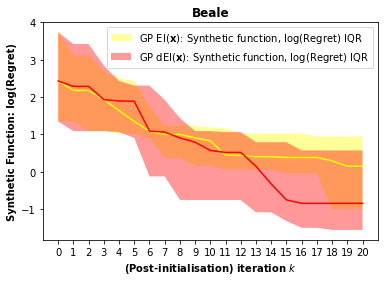

In [141]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


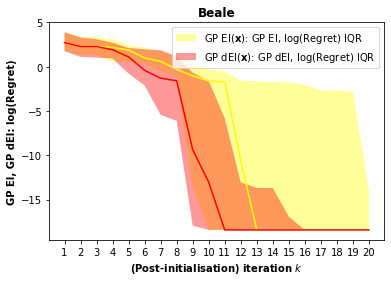

In [142]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx_acqFuncMin, color = 'Yellow')
plt.plot(median_exact_acqFuncMin, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approx_acqFuncMin, upper_approx_acqFuncMin, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): GP EI, log(Regret) IQR')
plt.fill_between(xstar, lower_exact_acqFuncMin, upper_exact_acqFuncMin, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): GP dEI, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()
